In [1]:
%reload_ext watermark
%matplotlib inline

import os
import glob
from scipy.stats import mannwhitneyu, zscore
from sklearn.linear_model import LogisticRegression
from contextlib import suppress
from metapool.metapool import *
from metapool.plate import PlateReplication
from metapool import (make_sample_sheet, requires_dilution, dilute_gDNA,
                      find_threshold, autopool, extract_stats_metadata, add_controls, compress_plates)
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2024-04-01T15:44:59.825543-07:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.15.0

metapool    : 0+untagged.174.g1997cd7
sample_sheet: 0.13.0
openpyxl    : 3.0.10

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Hostname: Caitrionas-MacBook-Pro.local

numpy     : 1.26.4
re        : 2.2.1
json      : 2.0.9
matplotlib: 3.8.0
pandas    : 2.2.1
seaborn   : 0.12.2



# Knight Lab shotgun pipeline notebook

### What is it?

This Jupyter Notebook allows you to automatically produce most of the files you need for completing the Knight Lab shotgun sequencing pipeline.

Hopefully, this will not only make it much easier to generate these files, but also keep our information more accurate.

### Here's how it should work.

You'll start out with a **basic plate map**, which just links each sample to it's approprite row and column.

Then you'll add the output of the MiniPico assay of sample DNA concentrations, which will enable to you to automatically make a **normalization pick list** for starting the shotgun library prep itself. You can also visualize these concentrations on the plate, allowing you to double check the plate map and DNA concentration read.

Next you'll automatically assign barcodes to each sample, producing an **index pick list** for barcode addition prior to PCR.

After finishing the shotgun library prep itself, you'll measure library concentration with qPCR. This qPCR data file will then be read in and used to estimate and visualize pooling parameters, producing a **pooling pick list**. 

Finally, the per-sample information from the whole run can be combined to automatically produce a **sample sheet** that you can give directly to IGM for sequencing. 

# Workflow for normalizing DNA

This portion of the notebook will read in the output of the mini-Pico quantification assay and construct an Echo normalization picklist file. 

As inputs, it requires:
1. A tab-delimited row-wise plate map that indicates the sample name, well location, and blank status of each sample on the 384 well plate.

You can use this google sheet template to generate your plate map:
https://docs.google.com/spreadsheets/d/1xPjB6iR3brGeG4bm2un4ISSsTDxFw5yME09bKqz0XNk/edit?usp=sharing

The workflow then:
1. reads in the plate map and constructs a dataframe
2. calculates volumes to be added via echo to reach desired input DNA quantity
3. produces an Echo-formatted pick list file

## Step 1: read in Sample Accession File
**Enter the correct path to the sample accession file**. This will serve as a source for relating all subsequent information.

In [2]:
sample_accession_fp = './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_16_17_18_21_sa_file.tsv'
if not os.path.isfile(sample_accession_fp):
    print("Problem! %s is not a path to a valid file" % file)

sample_accession_df = pd.read_csv(sample_accession_fp,dtype={'TubeCode':str,
                                                            'sample_name':str},
                                 sep='\t')
sample_accession_df.head()

,sample_name,TubeCode
0,23B.Day7.1,0359097394
1,23B.Day7.10,0359097402
2,23B.Day7.11,0359097385
3,23B.Day7.12,0359097375
4,23B.Day7.13,0359098882


## Step 2: Read in the sample info from Qiita

In [3]:
metadata_fp = './test_data/Plate_Maps/12986_20230314-090655.txt'
if not os.path.isfile(sample_accession_fp):
    print("Problem! %s is not a path to a valid file" % file)

metadata = pd.read_csv(metadata_fp, sep='\t')

metadata.head()

,sample_name,bacteria_strain,box_id,cage_id,collection_timepoint,collection_timestamp,dam,date_collected,date_colonized,decription,...,qiita_study_id,run,sample_type,scientific_name,sex,sire,taxon_id,title,tube_id,zarrinparlab_quant_ng_ul
0,12986.23B.Day7.1,AZ20,10,23,day7,2017-07-19 10:00,A1,7/19/17,7/12/17 0:00,23B.Day7.1,...,12986,1,fecal culture,mouse gut metagenome,male,A,410661,In Vivo Adaptation of Engineered Native Bacteria,23b-1_day7,78
1,12986.23B.Day7.10,AZ20,10,23,day7,2017-07-19 10:00,A1,7/19/17,7/12/17 0:00,23B.Day7.10,...,12986,1,fecal culture,mouse gut metagenome,male,A,410661,In Vivo Adaptation of Engineered Native Bacteria,23b-10_day7,53.3
2,12986.23B.Day7.11,AZ20,10,23,day7,2017-07-19 10:00,A1,7/19/17,7/12/17 0:00,23B.Day7.11,...,12986,1,fecal culture,mouse gut metagenome,male,A,410661,In Vivo Adaptation of Engineered Native Bacteria,23b-11_day7,80.6
3,12986.23B.Day7.12,AZ20,10,23,day7,2017-07-19 10:00,A1,7/19/17,7/12/17 0:00,23B.Day7.12,...,12986,1,fecal culture,mouse gut metagenome,male,A,410661,In Vivo Adaptation of Engineered Native Bacteria,23b-12_day7,49.1
4,12986.23B.Day7.13,AZ20,14,23,day7,2017-07-19 10:00,A1,7/19/17,7/12/17 0:00,23B.Day7.13,...,12986,1,fecal culture,mouse gut metagenome,male,A,410661,In Vivo Adaptation of Engineered Native Bacteria,23b-13_day7,48.6


## Step 3: Assign the Compression Layout and Fill in Appropriate Info.

In [4]:
compression_layout = [
    {
        # top left plate
        'Plate Position': 1, #as int
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_16_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_16', # Plate_#
        'Project Abbreviation' : 'ADAPT', # PROJECT ABBREVIATION
        'Plate elution volume': 70
        #'Plate_barcode': ''
        
#         'Plating': 'SF', # initials
#         'Extraction Kit Lot': '166032128',
#         'Extraction Robot': 'Carmen_HOWE_KF3',
#         'TM1000 8 Tool': '109379Z',
#         'Primer Date': '2021-08-17', # yyyy-mm-dd
#         'MasterMix Lot': '978215',
#         'Water Lot': 'RNBJ0628',
#         'TM10 8 Tool': '865HS8',
#         'Processing Robot': 'Echo550',
#         'TM300 8 Tool': 'not applicable',
#         'TM50 8 Tool': 'not applicable',
#         'instrument_model': 'Illumina MiSeq',
#         'run_date': '2023-03-02', # date of MiSeq run
#         'Original Name': '' # leave empty
    },
    {
        # top right plate
        'Plate Position': 2,
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_17_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_17', # Plate_#
        'Project Abbreviation' : 'ADAPT', # PROJECT ABBREVIATION
        'Plate elution volume': 70
        #'Plate_barcode': ''
        
#         'Plating': 'SF', # initials
#         'Extraction Kit Lot': '166032128',
#         'Extraction Robot': 'Carmen_HOWE_KF3',
#         'TM1000 8 Tool': '109379Z',
#         'Primer Date': '2021-08-17', # yyyy-mm-dd
#         'MasterMix Lot': '978215',
#         'Water Lot': 'RNBJ0628',
#         'TM10 8 Tool': '865HS8',
#         'Processing Robot': 'Echo550',
#         'TM300 8 Tool': 'not applicable',
#         'TM50 8 Tool': 'not applicable',
#         'instrument_model': 'Illumina MiSeq',
#         'run_date': '2023-03-02', # date of MiSeq run
#         'Original Name': '' # leave empty
    },
    {
        # bottom left plate
        'Plate Position': 3,
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_18_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_18', # Plate_#
        'Project Abbreviation' : 'ADAPT', # PROJECT ABBREVIATION
        'Plate elution volume': 70
        #'Plate_barcode': ''
        
#         'Plating': 'SF', # initials
#         'Extraction Kit Lot': '166032128',
#         'Extraction Robot': 'Carmen_HOWE_KF3',
#         'TM1000 8 Tool': '109379Z',
#         'Primer Date': '2021-08-17', # yyyy-mm-dd
#         'MasterMix Lot': '978215',
#         'Water Lot': 'RNBJ0628',
#         'TM10 8 Tool': '865HS8',
#         'Processing Robot': 'Echo550',
#         'TM300 8 Tool': 'not applicable',
#         'TM50 8 Tool': 'not applicable',
#         'instrument_model': 'Illumina MiSeq',
#         'run_date': '2023-03-02', # date of MiSeq run
#         'Original Name': '' # leave empty
    },
    {
        # bottom right plate
        'Plate Position': 4,
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_21_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_21', # Plate_#
        'Project Abbreviation' : 'ADAPT', # PROJECT ABBREVIATION
        'Plate elution volume': 70
        #'Plate_barcode': ''
        
#         'Plating': 'SF', # initials
#         'Extraction Kit Lot': '166032128',
#         'Extraction Robot': 'Carmen_HOWE_KF3',
#         'TM1000 8 Tool': '109379Z',
#         'Primer Date': '2021-08-17', # yyyy-mm-dd
#         'MasterMix Lot': '978215',
#         'Water Lot': 'RNBJ0628',
#         'TM10 8 Tool': '865HS8',
#         'Processing Robot': 'Echo550',
#         'TM300 8 Tool': 'not applicable',
#         'TM50 8 Tool': 'not applicable',
#         'instrument_model': 'Illumina MiSeq',
#         'run_date': '2023-03-02', # date of MiSeq run
#         'Original Name': '' # leave empty
    },
]


In [5]:
well_col='Well'
plate_df = compress_plates(compression_layout,sample_accession_df,well_col=well_col)

In [6]:
blanks_dir = './test_data/BLANKS'
katharoseq_dir = './test_data/katharoseq'

plate_df = add_controls(plate_df,blanks_dir,katharoseq_dir)

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:1750: UserWarning: Controls added
  warnings.warn('Controls added')


## Validate plate dataframe

In [7]:
validate_plate_df(plate_df,metadata,sample_accession_df,blanks_dir,katharoseq_dir)

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:1792: UserWarning: There are 27 control samples in this plate
  warnings.warn(f"There are {len(control_samples)} control samples"
/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:1803: UserWarning: There are 357 samples with associated metadata in this plate
  warnings.warn(f"There are {len(samples_in_metadata)} samples with "
/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:1811: UserWarning: All samples have associated metadata :D
  warnings.warn("All samples have associated metadata :D")
/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:1855: UserWarning: All TubeCodes have associated data :D
  warnings.warn("All TubeCodes have associated data :D")


## Step 4: read in DNA concentrations and add to plate map

**Enter the correct path to the Pico DNA concentration output**. This should be a csv-formatted file produced by the MiniPico assay on the condensed, 384-well plate. 

In [8]:
sample_concs_fp = './test_data/Quant/MiniPico/2022_07_Celeste_Adaptation_16_17_18_21_gDNA_quant.txt'

if not os.path.isfile(sample_concs_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the DNA concentration output file**. It should look something like this:
    
```
Results

Well ID	Well	[Blanked-RFU]	[Concentration]
SPL1	A1	5243.000	3.432
SPL2	C1	4949.000	3.239
SPL3	E1	15302.000	10.016
SPL4	G1	4039.000	2.644
SPL5	I1	12862.000	8.419
SPL6	K1	2840.000	1.859
SPL7	M1	3343.000	2.188
```

In [9]:
sample_concs = read_pico_csv(sample_concs_fp, plate_reader='SpectraMax_i3x')

plate_df = pd.merge(plate_df, sample_concs, on=well_col)

plate_df.head(50)

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,Time,TubeCode,Well,vol_extracted_elution_ul,well_id_96,description,Kathseq_RackID,number_of_cells,Blank,Sample DNA Concentration
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132553,A1,70,A1,NaN,NaN,NaN,False,2.472
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132554,A3,70,A2,NaN,NaN,NaN,False,2.735
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132555,A5,70,A3,NaN,NaN,NaN,False,2.988
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132556,A7,70,A4,NaN,NaN,NaN,False,1.995
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132557,A9,70,A5,NaN,NaN,NaN,False,1.457
5,41B.Month6.14,6,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132558,A11,70,A6,NaN,NaN,NaN,False,1.752
6,41B.Month6.15,7,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132559,A13,70,A7,NaN,NaN,NaN,False,1.340
7,41B.Month6.16,8,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132560,A15,70,A8,NaN,NaN,NaN,False,2.637
8,41B.Month6.17,9,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132561,A17,70,A9,NaN,NaN,NaN,False,2.269
9,41B.Month6.18,10,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132562,A19,70,A10,NaN,NaN,NaN,False,2.650


In [10]:
if requires_dilution(plate_df,threshold=10,tolerance=.10):
    plate_df = dilute_gDNA(plate_df,threshold=10)
    print('You need to make a 1:10 gDNA dilution plate.')
else:
    plate_df['extracted_gdna_concentration_ng_ul'] = plate_df['Sample DNA Concentration'].copy()
    plate_df['Diluted'] = False
    print('Proceed w/out gDNA dilutions')


Proceed w/out gDNA dilutions


**Visualize plate DNA concentrations and plate map:**

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


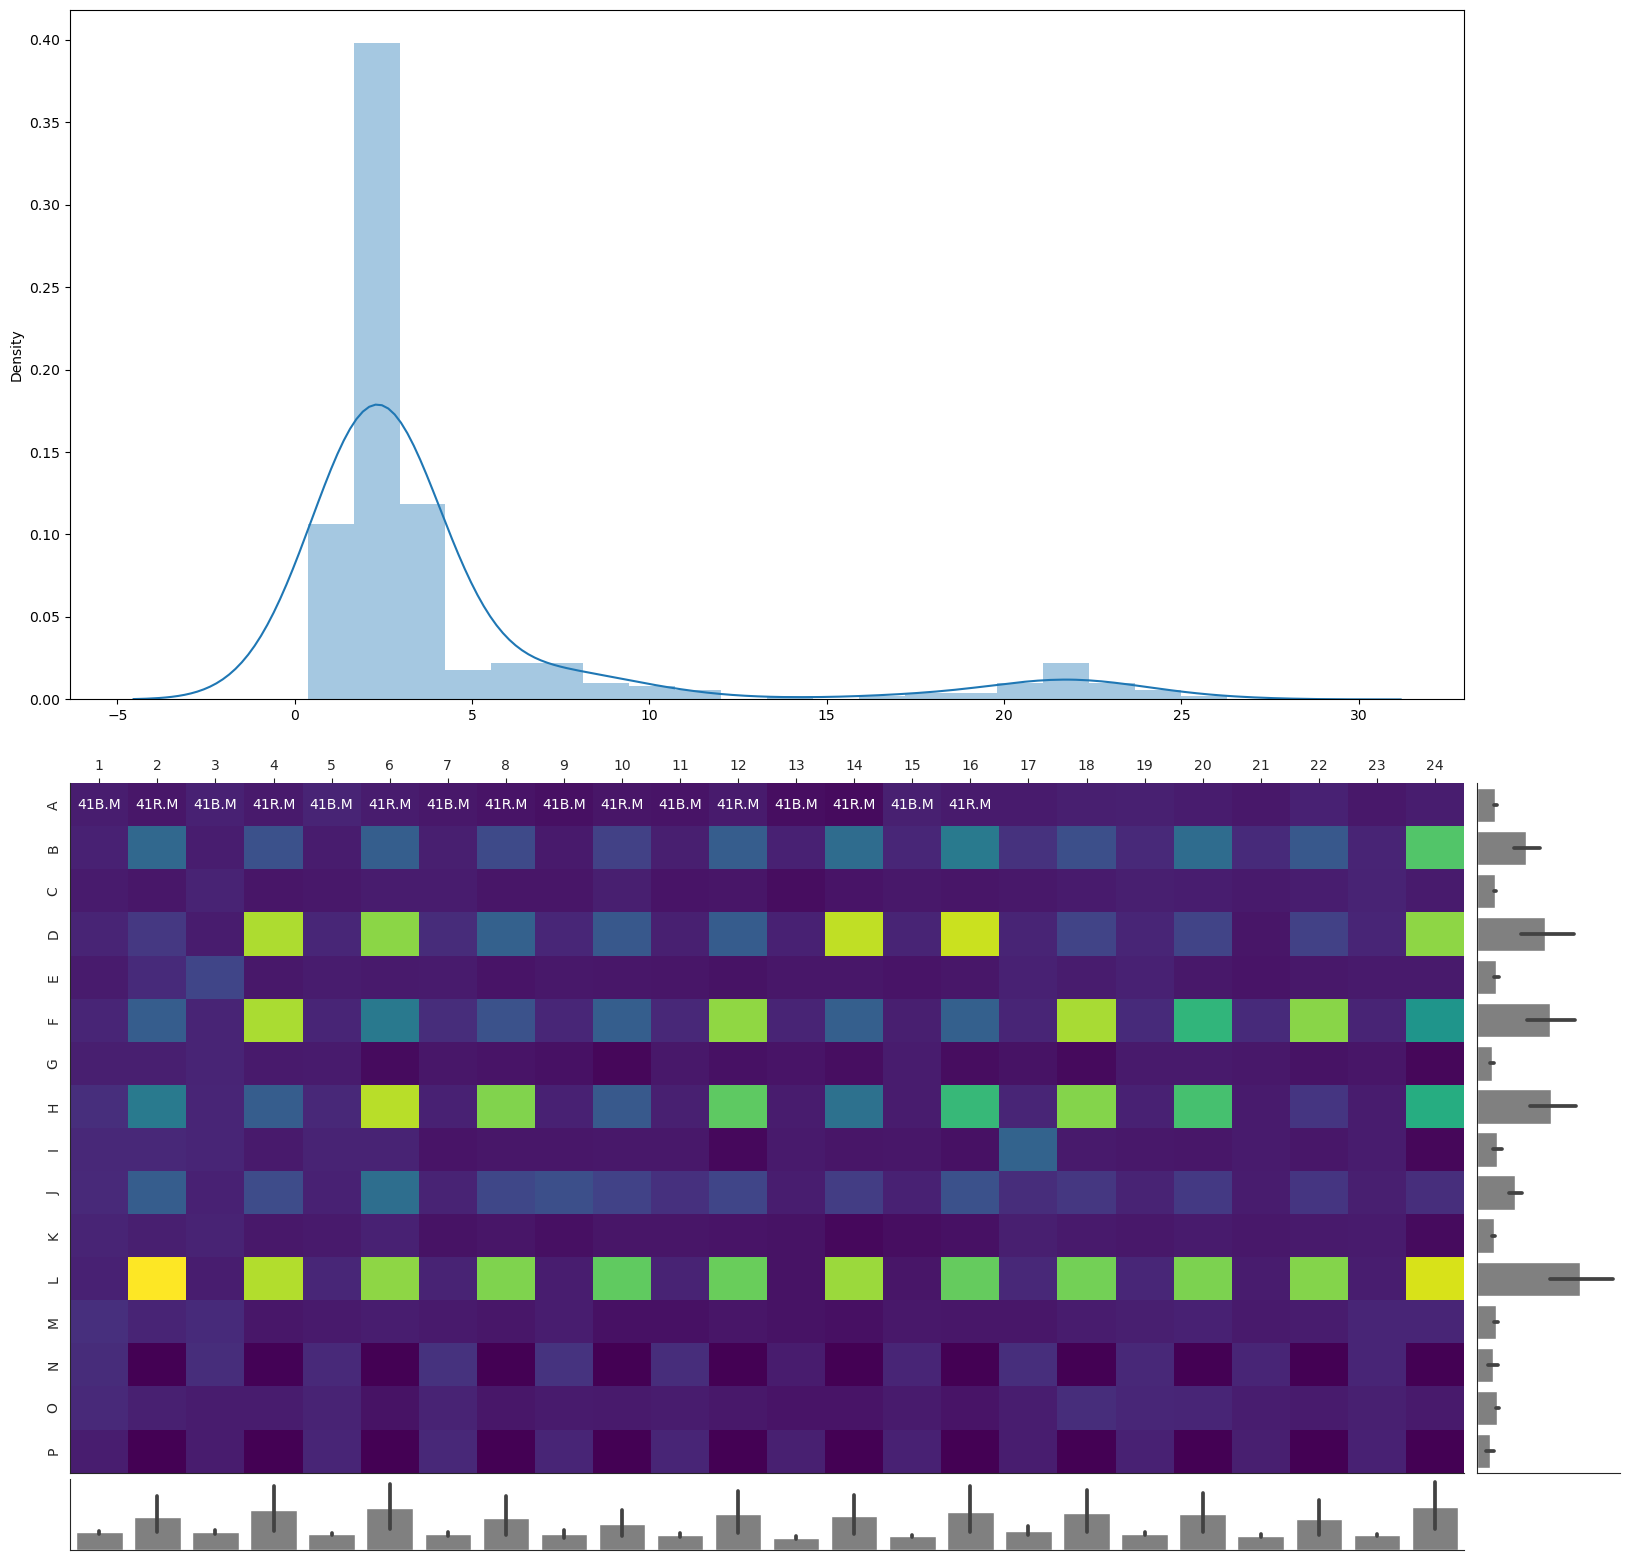

In [11]:
# get DNA concentratin information
dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)

plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')

### Make sample replicates

In [12]:
# Examples of replicates

# replicate_dict = {source1_quadrant:destination1_quadrant}
# replicate_dict = {source1_quadrant:[destination1_quadrants,destination1_quadrants]}

#replicate_dict = {1:[2,3]}

# initialize a new PlateReplication object to manage metadata, conversions, and more for you.
# initialize w/preferred well_col.
well_col = 'Library Well'
pr = PlateReplication(well_col)

# set overwrite=False to detect any overwriting of source or destination quads and raise an Error.
# replace replicates = None with replicates = replicate_dict to make replicates
plate_df = pr.make_replicates(plate_df, replicates=None, overwrite=True)

#replicates overlapping sample_wells for other samples shuld raise warning, but will be allowed
if 'True' in plate_df['contains_replicates'].unique():
    plate_df['contains_replicates'] = True
    # get DNA concentratin information
    dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

    # get information for annotation
    names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)

    plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.6s')
else:
    plate_df['contains_replicates'] = False

In [13]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### gDNA concentration heatmap, Plate 1

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


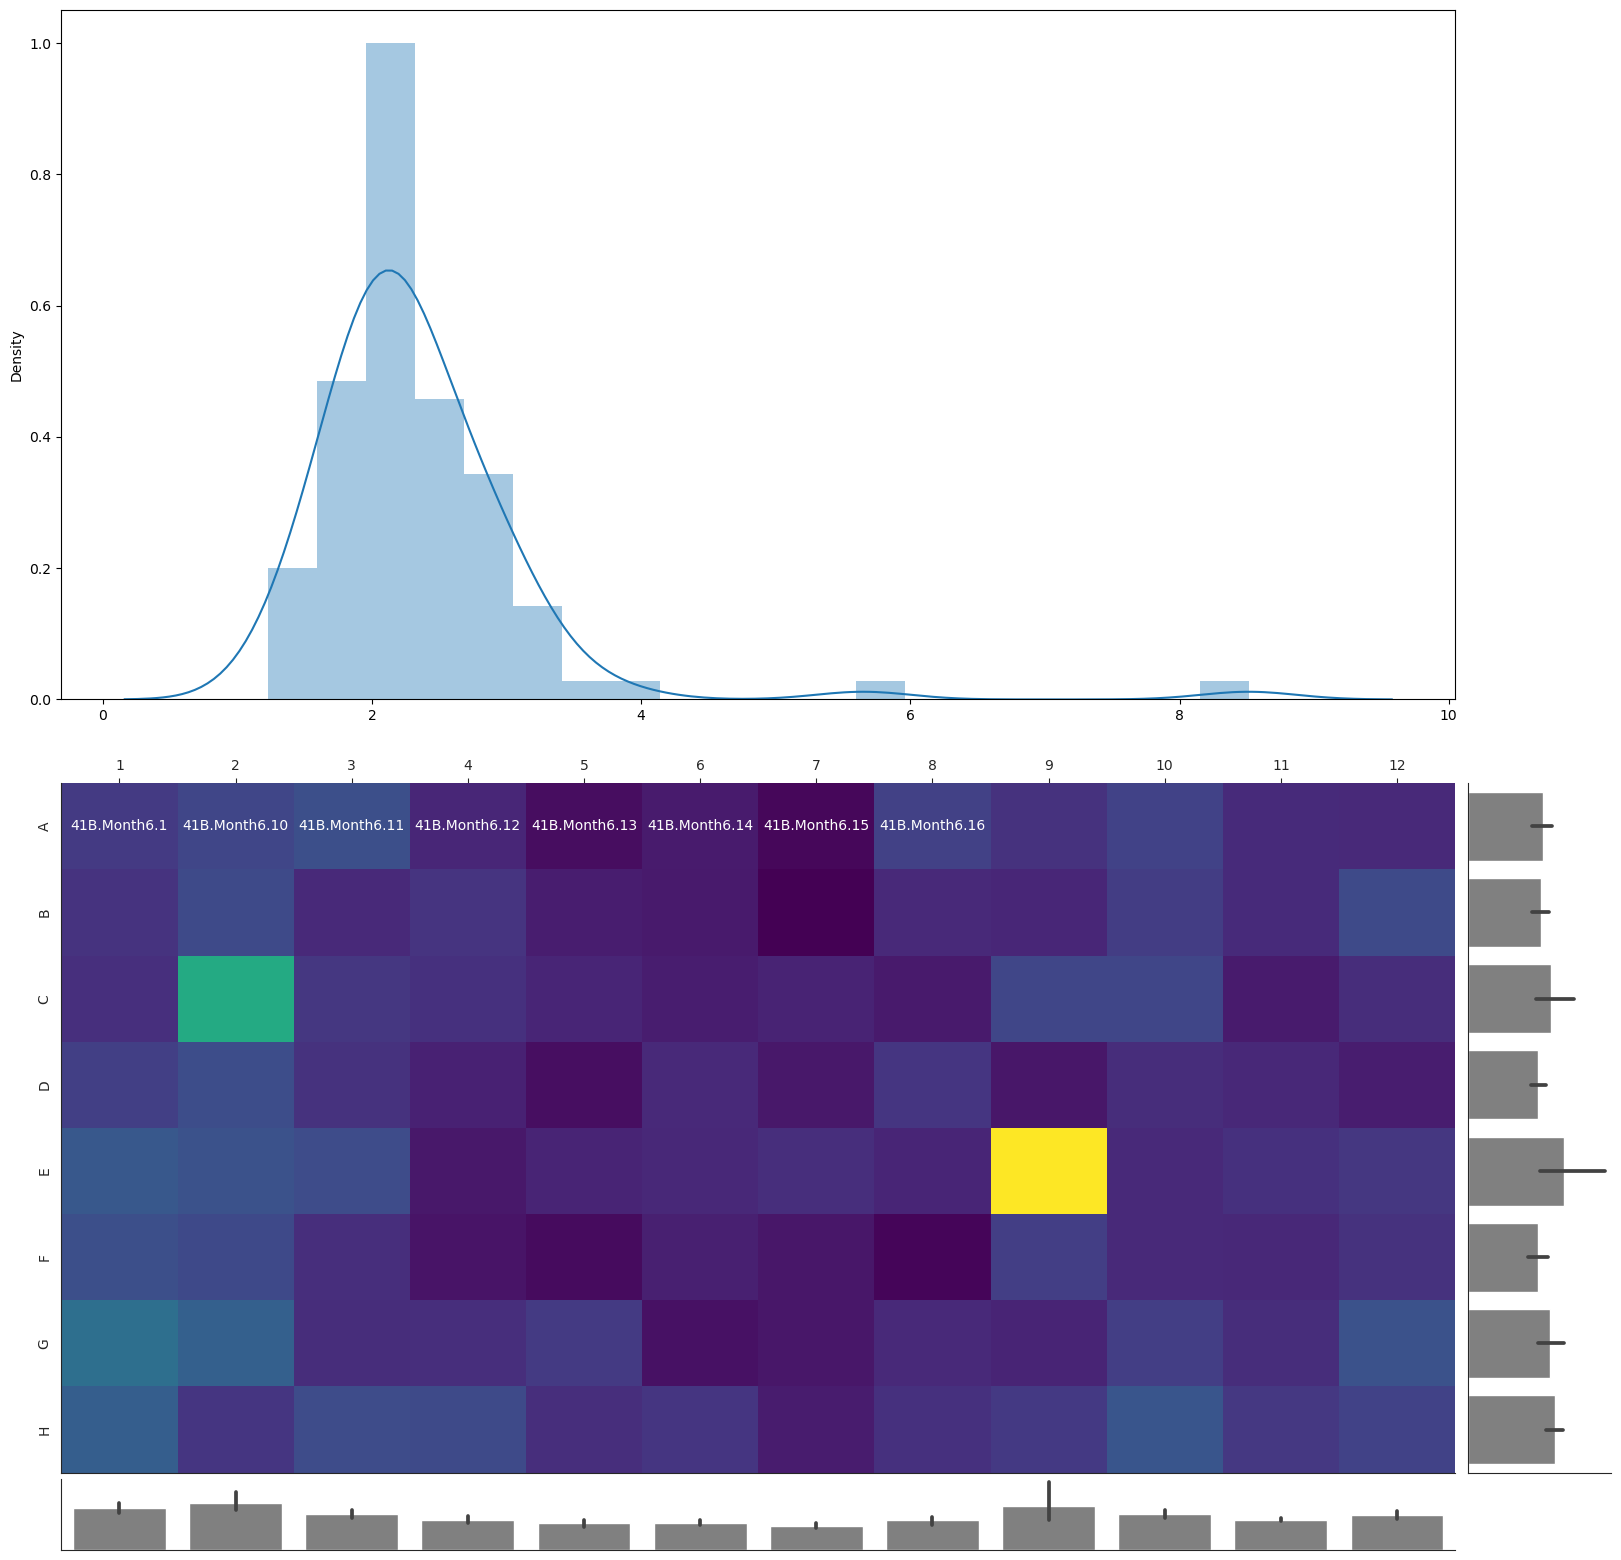

In [14]:
plot_plate_vals(dna_concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='')

### gDNA concentration heatmap, Plate 2

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


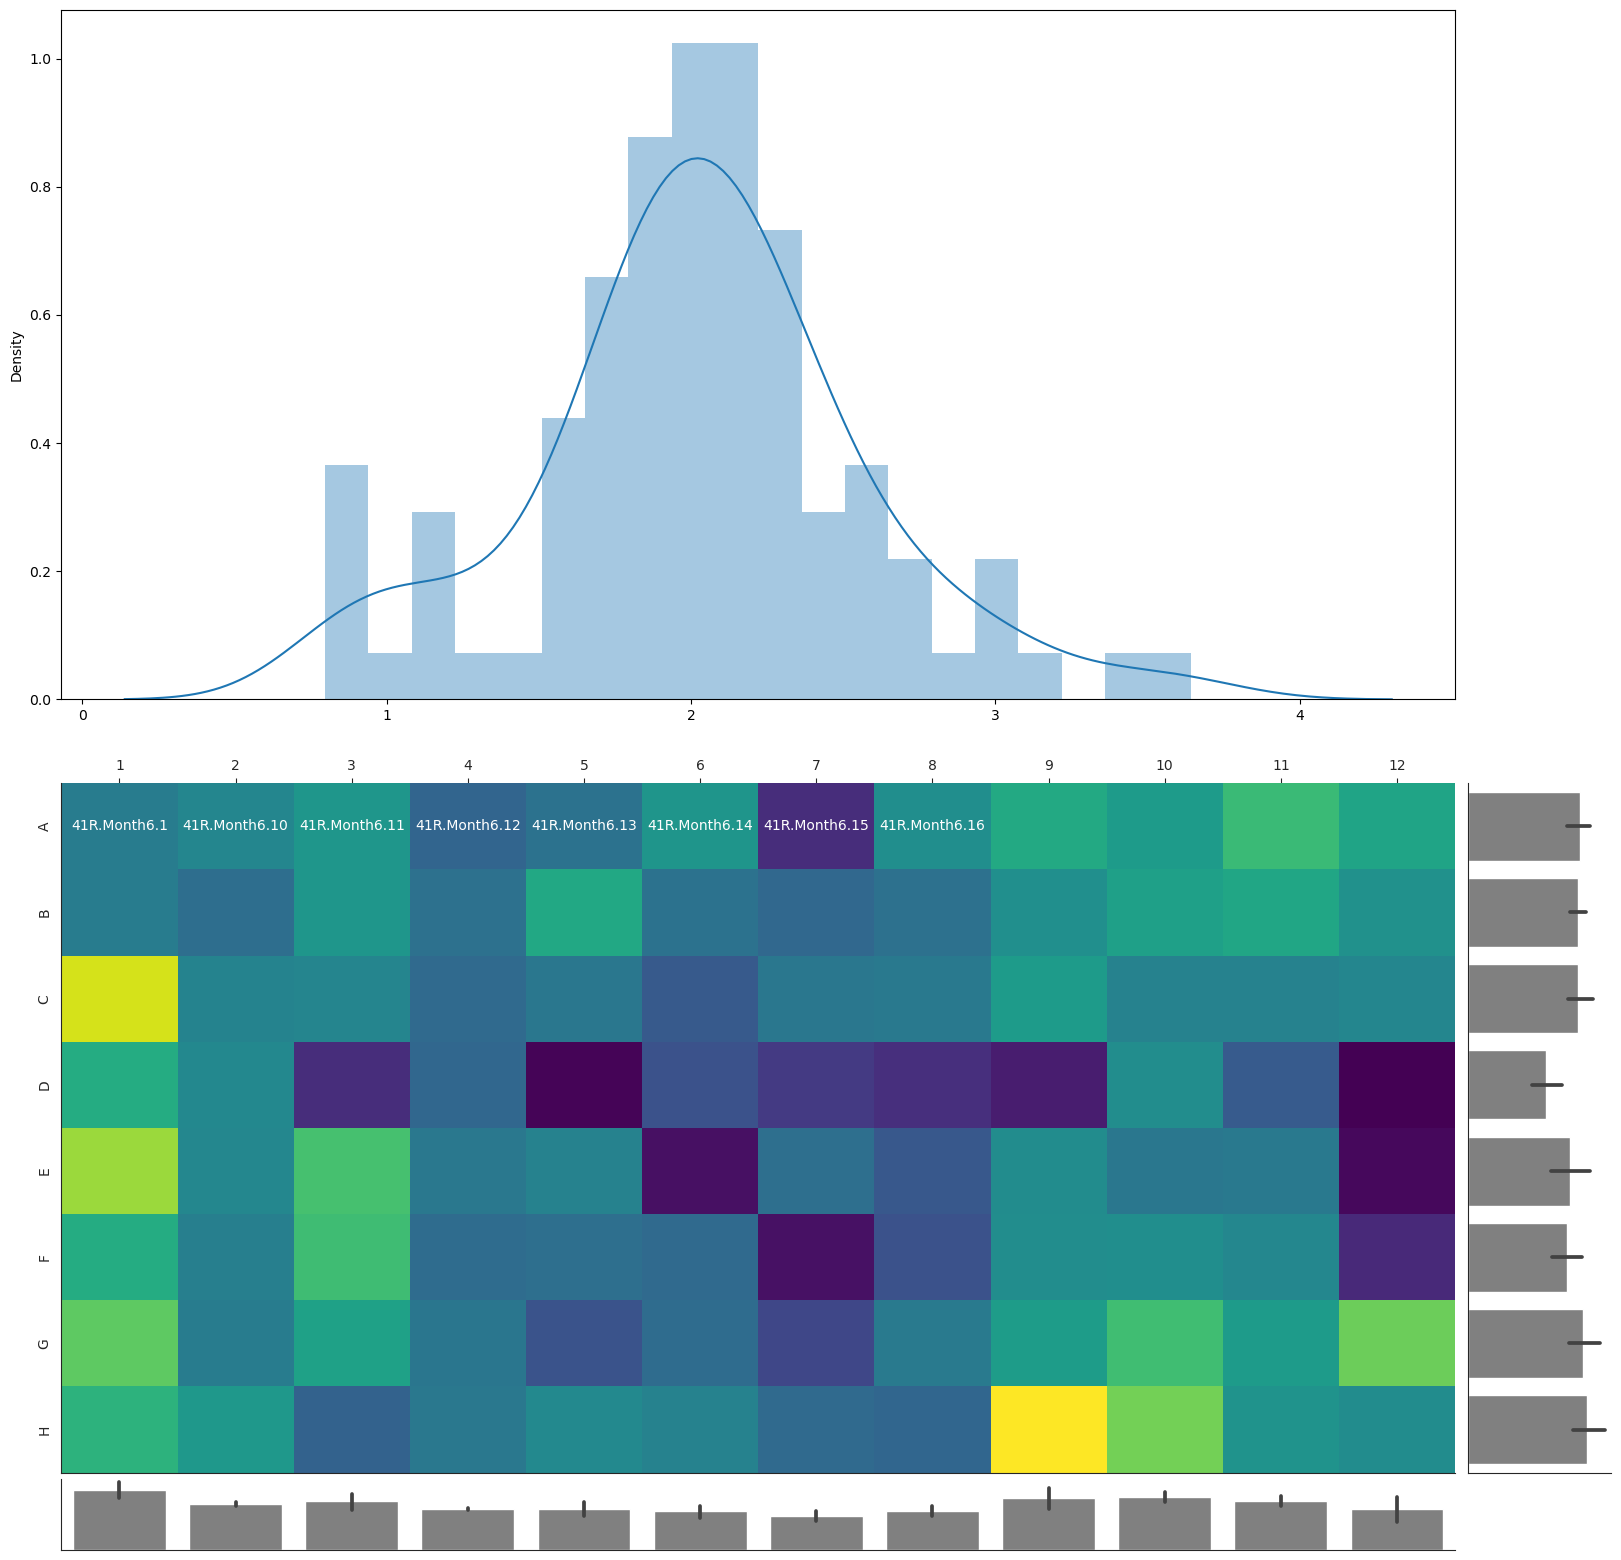

In [15]:
plot_plate_vals(dna_concs[np.ix_(even_rows,odd_cols)],
                    annot_str= names[np.ix_(even_rows,odd_cols)],
                    color_map='viridis',
                    annot_fmt='')

### gDNA concentration heatmap, Plate 3

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


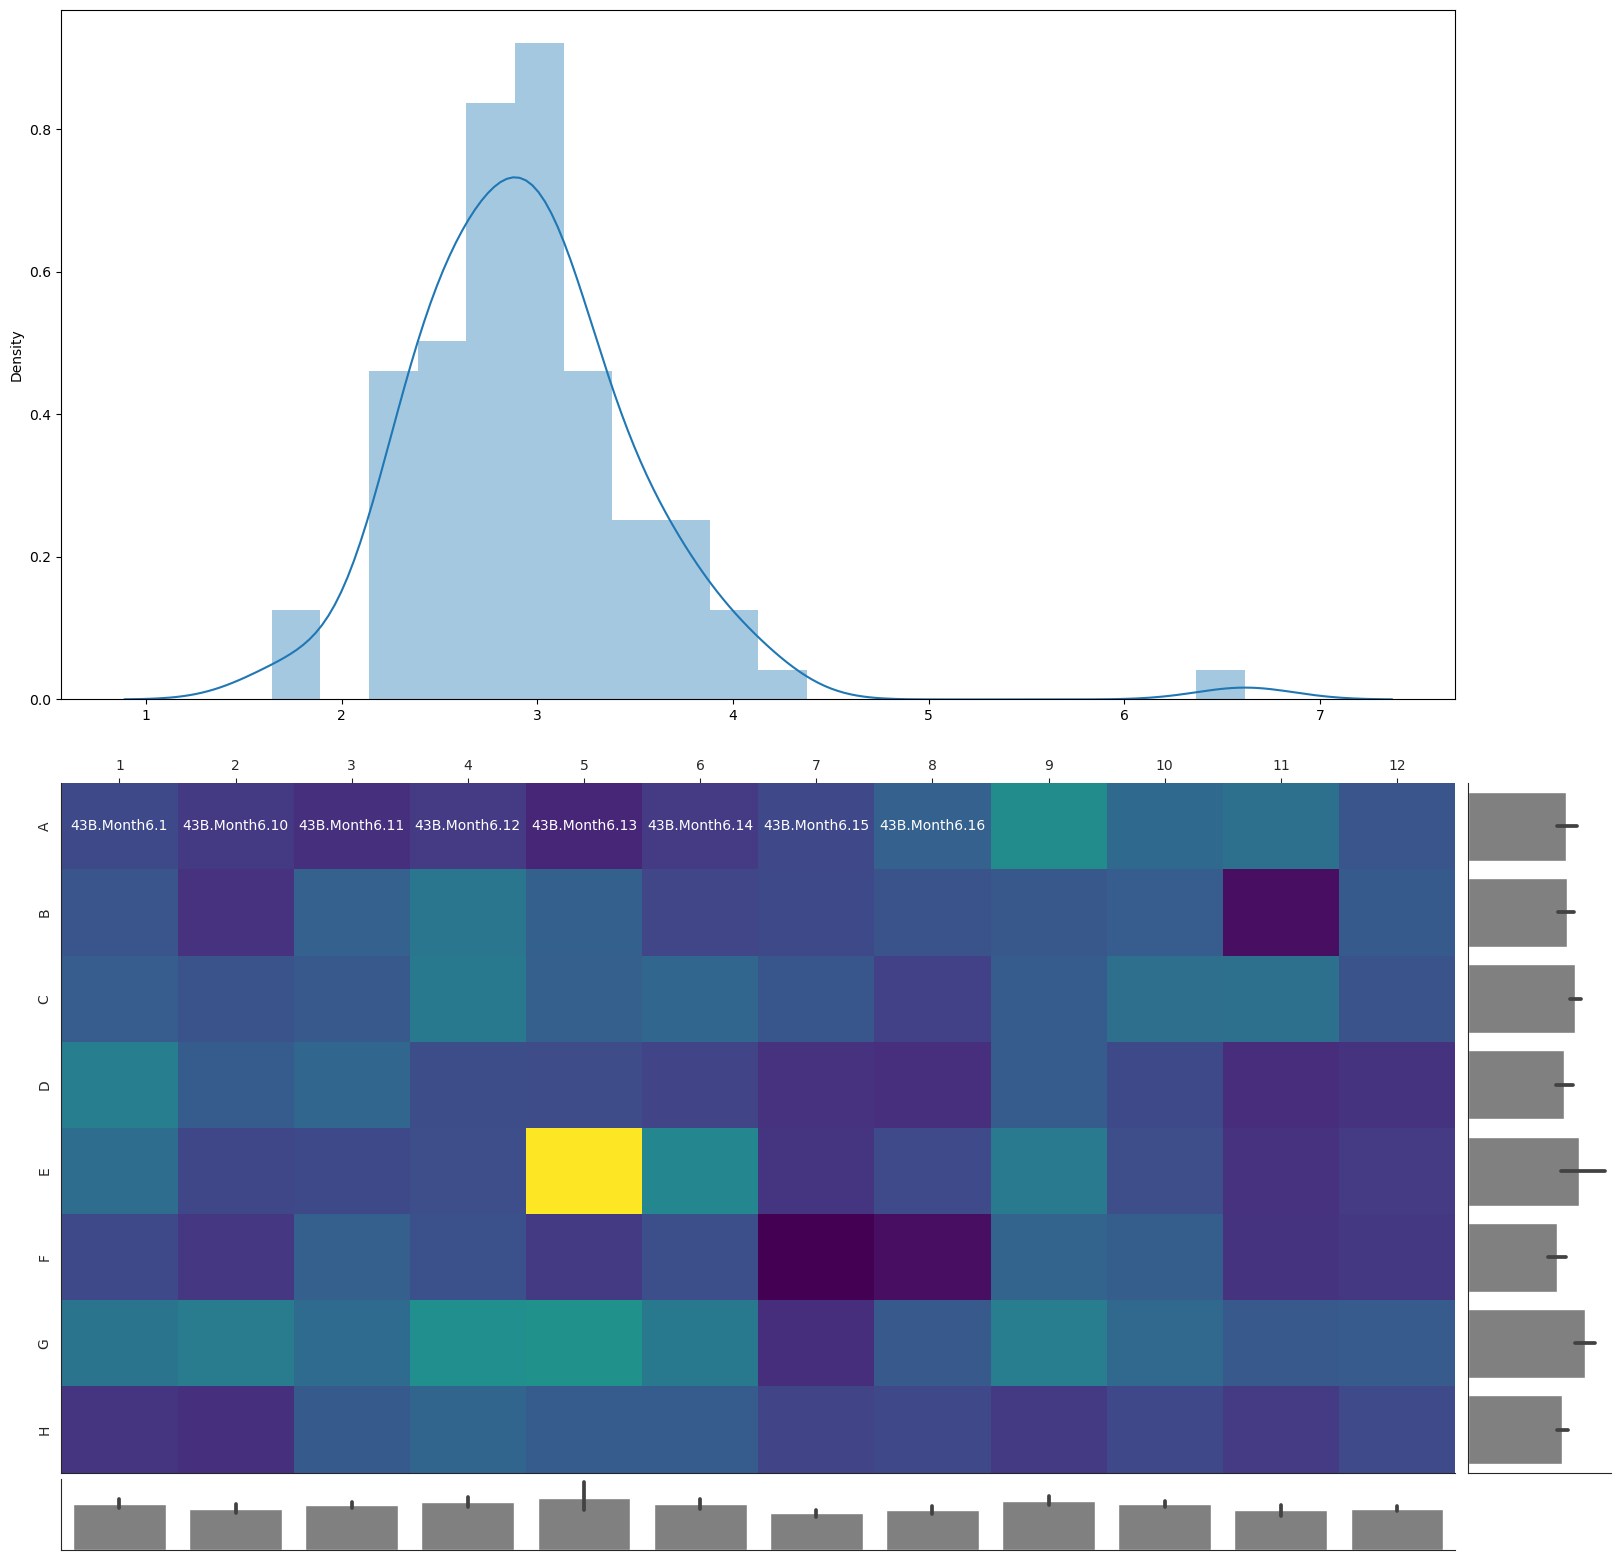

In [16]:
plot_plate_vals(dna_concs[np.ix_(odd_rows,even_cols)],
                    annot_str= names[np.ix_(odd_rows,even_cols)],
                    color_map='viridis',
                    annot_fmt='')

### gDNA concentration heatmap, Plate 4

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


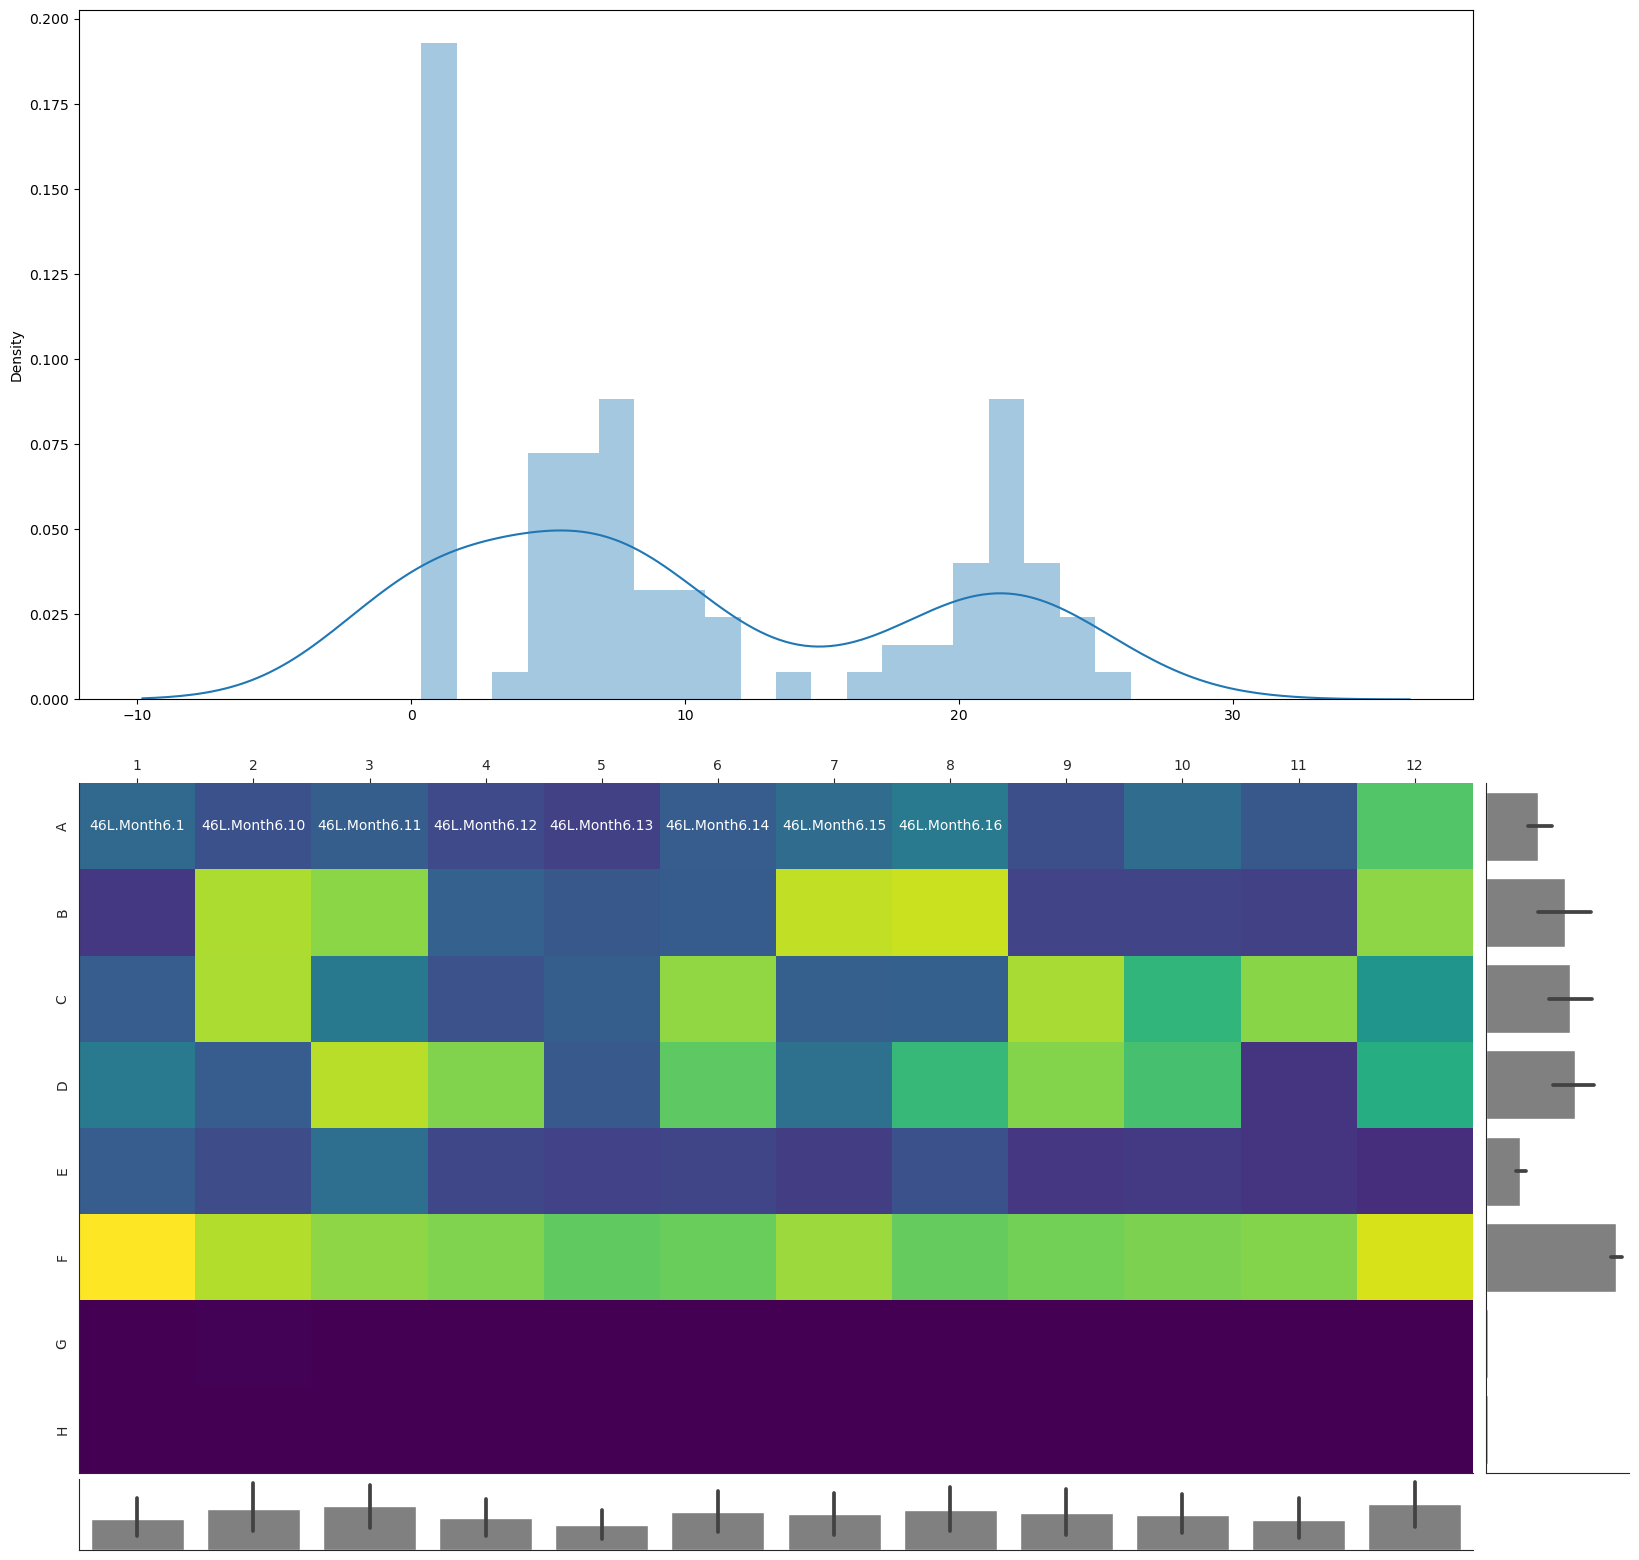

In [17]:
plot_plate_vals(dna_concs[np.ix_(odd_rows,odd_cols)],
                    annot_str= names[np.ix_(odd_rows,odd_cols)],
                    color_map='viridis',
                    annot_fmt='')

## Step 3: calculate normalization volumes and add to plate map

This step will calculate volumes for the DNA normalization pick list.

Check the desired values for:
 - **`ng`**: the desired quantity of DNA in normed plate, in ng
 - **`total_vol`**: the total volume of normalized DNA, in nL
 - **`min_vol`**: the minimum quantity of sample to add, in nL
 - **`resolution`**: the resolution of the Echo, in nL (usually 2.5)

In [18]:
ng = 5
total_vol = 3500
min_vol = 25
resolution = 2.5

dna_vols = calculate_norm_vol(plate_df['Sample DNA Concentration'], ng=ng, min_vol=min_vol, max_vol=total_vol, resolution=resolution)
water_vols = total_vol - dna_vols

plate_df['Normalized DNA volume'] = dna_vols
plate_df['Normalized water volume'] = water_vols

plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,Kathseq_RackID,number_of_cells,Blank,Sample DNA Concentration,extracted_gdna_concentration_ng_ul,Diluted,Library Well,contains_replicates,Normalized DNA volume,Normalized water volume
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,2.472,2.472,False,A1,False,2022.5,1477.5
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,2.735,2.735,False,A3,False,1827.5,1672.5
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,2.988,2.988,False,A5,False,1672.5,1827.5
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,1.995,1.995,False,A7,False,2507.5,992.5
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,1.457,1.457,False,A9,False,3432.5,67.5


### Step 3a (optional): Add synDNA spike-in

In [19]:
plate_df = add_syndna(plate_df,syndna_pool_number=None,syndna_concentration=2.22)

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:1454: UserWarning: Returning input plate dataframe;no synDNA will be added to this prep
  warnings.warn('Returning input plate dataframe;'


In [20]:
if plate_df['syndna_pool_number'].unique()!= None:
    syndna_well='A1'
    syndna_plate = 'synDNA plate'
    syndna_picklist = format_dna_norm_picklist(np.array(plate_df['synDNA volume']),
                                             np.zeros(plate_df.shape[0]),
                                             np.repeat(syndna_well,plate_df.shape[0]),
                                             dest_wells = np.array(plate_df[well_col]),
                                             sample_names = np.array(plate_df['Sample']),
                                             sample_plates = np.repeat(syndna_plate,plate_df.shape[0]))

In [21]:
if plate_df['syndna_pool_number'].unique() != None:
    # Write the picklist as .txt
    syndna_picklist_fp = './test_output/Input_Norm/YYYY_MM_DD_Celeste_Adaptation_16-21_syndna.txt'

    if os.path.isfile(syndna_picklist_fp):
        print("Warning! This file exists already.")

In [22]:
if plate_df['syndna_pool_number'].unique() != None:
    with open(syndna_picklist_fp, 'w') as f:
        f.write(syndna_picklist)

    !head {syndna_picklist_fp}

## Step 4: make pick list

Format the Echo-compatible pick list.

In [23]:
norm_picklist = format_dna_norm_picklist(np.array(plate_df['Normalized DNA volume']),
                                         np.array(plate_df['Normalized water volume']),
                                         np.array(plate_df['Well']),
                                         dest_wells = np.array(plate_df[well_col]),
                                         sample_names = np.array(plate_df['Sample']),
                                         sample_plates = np.array(plate_df['Compressed Plate Name']),
                                         dna_concs = np.array(plate_df['Sample DNA Concentration']))

## Step 5: write pick list to file

In [24]:
# Write the picklist as .txt
norm_picklist_fp = './test_output/Input_Norm/YYYY_MM_DD_Celeste_Adaptation_16-21_inputnorm.txt'

if os.path.isfile(norm_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [25]:
with open(norm_picklist_fp, 'w') as f:
    f.write(norm_picklist)
    
!head {norm_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Concentration	Transfer Volume	Destination Plate Name	Destination Well
41B.Month6.1	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A1	2.472	2022.5	NormalizedDNA	A1
41B.Month6.10	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A3	2.735	1827.5	NormalizedDNA	A3
41B.Month6.11	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A5	2.988	1672.5	NormalizedDNA	A5
41B.Month6.12	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A7	1.995	2507.5	NormalizedDNA	A7
41B.Month6.13	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A9	1.457	3432.5	NormalizedDNA	A9
41B.Month6.14	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A11	1.752	2855.0	NormalizedDNA	A11
41B.Month6.15	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A13	1.34	3500.0	NormalizedDNA	A13
41B.Month6.16	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A15	2.637	1895.0	NormalizedDNA	A15
41B.Month6.17	Celeste_Adaptation_12986_16_17_18_21	384PP_AQ_BP2	A17	2.269	2202.5	NormalizedDNA	

# Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate map dataframe (from previous step)
2. A tab-delimited index combination file, relating index combinations, i5 and i7 index values, and i5 and i7 index locations

The workflow then:
1. reads in the index combo list
2. assigns indices per sample
3. produces an Echo-formatted pick list file

## Step 1: Read in index combo list

This is a file that contains every possible i5 and i7 barcode combo on a separate line,
along with plate and well location information. It should look something like this:

```
index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,AGTGGCAACTGTGTTG,iTru5_01_B,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate
2,CACAGACTTGAGGTGT,iTru5_01_C,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate
3,CGACACTTGATCCATG,iTru5_01_D,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate
4,GACTTGTGGCCTATCA,iTru5_01_E,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate
5,GTGAGACTAACAACCG,iTru5_01_F,GTGAGACT,F1,iTru5_plate,iTru7_101_06,AACAACCG,A6,iTru7_plate
6,GTTCCATGACTCGTTG,iTru5_01_G,GTTCCATG,G1,iTru5_plate,iTru7_101_07,ACTCGTTG,A7,iTru7_plate
7,TAGCTGAGCCTATGGT,iTru5_01_H,TAGCTGAG,H1,iTru5_plate,iTru7_101_08,CCTATGGT,A8,iTru7_plate
8,CTTCGCAATGTACACC,iTru5_02_A,CTTCGCAA,I1,iTru5_plate,iTru7_101_09,TGTACACC,A9,iTru7_plate
```

In [26]:
index_combo_fp = './test_output/iTru/new_iTru_combos_Dec2017.csv'

if not os.path.isfile(index_combo_fp):
    print("Problem! %s is not a path to a valid file" % file)

In [27]:
index_combos = pd.read_csv(index_combo_fp)
index_combos.head()

,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,1,CTTCGCAACTGTGTTG,iTru5_02_A,CTTCGCAA,A3,iTru5_plate,iTru7_101_02,CTGTGTTG,A3,iTru7_plate
2,2,AACACCACTGAGGTGT,iTru5_03_A,AACACCAC,A5,iTru5_plate,iTru7_101_03,TGAGGTGT,A5,iTru7_plate
3,3,CGTATCTCGATCCATG,iTru5_04_A,CGTATCTC,A7,iTru5_plate,iTru7_101_04,GATCCATG,A7,iTru7_plate
4,4,GGTACGAAGCCTATCA,iTru5_05_A,GGTACGAA,A9,iTru5_plate,iTru7_101_05,GCCTATCA,A9,iTru7_plate


## Step 2: Assign index combo

This will pick a set of index combos from the index combo for the number of samples in the `plate_df` DataFrame.

Keep track of the barcode combinations used in the lab, and set `starting_combo` equal to the next unused combination.

One of way of doing that might be to keep track of the number of plates run, and set `starting_combo` equal to
384 * number of plates run + 1.

In [28]:
plate_counter = 144

starting_combo = ((plate_counter - 1) % 384) * 384

indices = assign_index(len(plate_df['Sample']), index_combos, start_idx=starting_combo).reset_index()

plate_df = pd.concat([plate_df, indices], axis=1)

plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54912,ACCGACAAACGATGAC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_112_12,ACGATGAC,G24,iTru7_plate
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54913,CTTCGCAACGTTATGC,iTru5_02_A,CTTCGCAA,A3,iTru5_plate,iTru7_113_01,CGTTATGC,I2,iTru7_plate
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54914,AACACCACGATACTGG,iTru5_03_A,AACACCAC,A5,iTru5_plate,iTru7_113_02,GATACTGG,I4,iTru7_plate
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54915,CGTATCTCCTACTTGG,iTru5_04_A,CGTATCTC,A7,iTru5_plate,iTru7_113_03,CTACTTGG,I6,iTru7_plate
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54916,GGTACGAACATACCAC,iTru5_05_A,GGTACGAA,A9,iTru5_plate,iTru7_113_04,CATACCAC,I8,iTru7_plate


## Step 3: Make index pick list

Format the Echo-compatible pick list.

In [29]:
index_picklist = format_index_picklist(plate_df['Sample'], plate_df[well_col], indices)

## Step 5: write pick list to file

In [30]:
# Write the picklist as .txt
index_picklist_fp = './test_output/Indices/YYYY_MM_DD_Celeste_Adaptation_16-21_indices.txt'

if os.path.isfile(index_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [31]:
with open(index_picklist_fp, 'w') as f:
    f.write(index_picklist)

!head {index_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Transfer Volume	Index Name	Index Sequence	Index Combo	Destination Plate Name	Destination Well
41B.Month6.1	iTru5_plate	384LDV_AQ_B2	A1	250	iTru5_01_A	ACCGACAA	54912	IndexPCRPlate	A1
41B.Month6.10	iTru5_plate	384LDV_AQ_B2	A3	250	iTru5_02_A	CTTCGCAA	54913	IndexPCRPlate	A3
41B.Month6.11	iTru5_plate	384LDV_AQ_B2	A5	250	iTru5_03_A	AACACCAC	54914	IndexPCRPlate	A5
41B.Month6.12	iTru5_plate	384LDV_AQ_B2	A7	250	iTru5_04_A	CGTATCTC	54915	IndexPCRPlate	A7
41B.Month6.13	iTru5_plate	384LDV_AQ_B2	A9	250	iTru5_05_A	GGTACGAA	54916	IndexPCRPlate	A9
41B.Month6.14	iTru5_plate	384LDV_AQ_B2	A11	250	iTru5_06_A	CGATCGAT	54917	IndexPCRPlate	A11
41B.Month6.15	iTru5_plate	384LDV_AQ_B2	A13	250	iTru5_07_A	AAGACACC	54918	IndexPCRPlate	A13
41B.Month6.16	iTru5_plate	384LDV_AQ_B2	A15	250	iTru5_08_A	CATCTGCT	54919	IndexPCRPlate	A15
41B.Month6.17	iTru5_plate	384LDV_AQ_B2	A17	250	iTru5_09_A	CTCTCAGA	54920	IndexPCRPlate	A17


# Workflow for calculating pooling

This portion of the notebook calculates pooling based on fluorescente quantification values, and produces visual outputs to interpret and check values. 

As inputs, this workflow requires:
1. A plate map DataFrame (from previous step)
2. MiniPico output (tab-delimited text format with columns 'Concentration' and 'Well')

The workflow:
1. reads in MiniPico output and calculates estimated library concentration
4. calculates pooling values and generates an Echo pick list

## Step 1: read in MiniPico library concentration

#### Enter correct path to MiniPico file:

In [32]:
lib_concs_fp = './test_data/Quant/MiniPico/2022_07_Celeste_Adaptation_16_17_18_21_CleanLib_quant.txt'

In [33]:
lib_concs = read_pico_csv(lib_concs_fp, plate_reader='SpectraMax_i3x',
                          conc_col_name='MiniPico Library DNA Concentration')
lib_concs.rename(columns={'Well':well_col},inplace=True)
plate_df = pd.merge(plate_df, lib_concs, on=well_col)

plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,MiniPico Library DNA Concentration
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,ACCGACAAACGATGAC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_112_12,ACGATGAC,G24,iTru7_plate,0.566
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,CTTCGCAACGTTATGC,iTru5_02_A,CTTCGCAA,A3,iTru5_plate,iTru7_113_01,CGTTATGC,I2,iTru7_plate,0.680
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,AACACCACGATACTGG,iTru5_03_A,AACACCAC,A5,iTru5_plate,iTru7_113_02,GATACTGG,I4,iTru7_plate,0.868
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,CGTATCTCCTACTTGG,iTru5_04_A,CGTATCTC,A7,iTru5_plate,iTru7_113_03,CTACTTGG,I6,iTru7_plate,0.740
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,GGTACGAACATACCAC,iTru5_05_A,GGTACGAA,A9,iTru5_plate,iTru7_113_04,CATACCAC,I8,iTru7_plate,1.431


## Step 2: calculate sample concentration from MiniPico

You will want to make sure that 'size' is correct for your average library size.

In [52]:
plate_df['MiniPico Library Concentration'] = compute_pico_concentration(plate_df['MiniPico Library DNA Concentration'],
                                                                        size=500)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,MiniPico Pooled Volume
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,A1,iTru5_plate,iTru7_112_12,ACGATGAC,G24,iTru7_plate,0.566,1.715152,4.999620,494.791667
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,A3,iTru5_plate,iTru7_113_01,CGTTATGC,I2,iTru7_plate,0.680,2.060606,4.998212,494.791667
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,A5,iTru5_plate,iTru7_113_02,GATACTGG,I4,iTru7_plate,0.868,2.630303,4.997430,494.791667
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,A7,iTru5_plate,iTru7_113_03,CTACTTGG,I6,iTru7_plate,0.740,2.242424,5.002463,494.791667
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_21,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,A9,iTru5_plate,iTru7_113_04,CATACCAC,I8,iTru7_plate,1.431,4.336364,5.001152,494.791667


## Step 3: visualization of MiniPico values

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

### Library concentration by sample DNA concentration:

/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


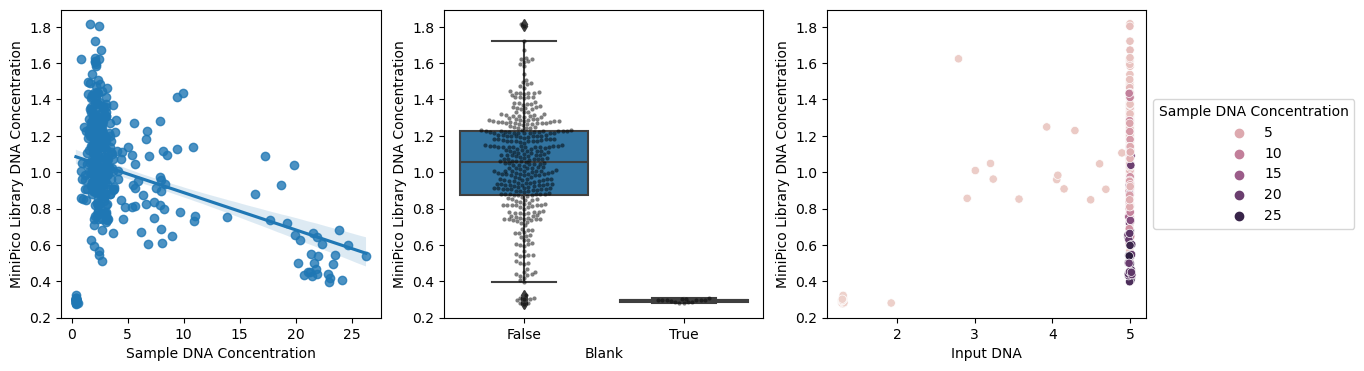

In [35]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
plate_df['Input DNA'] = plate_df['Sample DNA Concentration']*plate_df['Normalized DNA volume']/1000
sns.regplot(x="Sample DNA Concentration", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax1);
sns.boxplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2);
sns.swarmplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2,
              size=3,color='black',alpha=0.5)
sns.scatterplot( x="Input DNA",y="MiniPico Library DNA Concentration",hue='Sample DNA Concentration',data=plate_df ,ax = ax3);
ax3.legend(title='Sample DNA Concentration',loc='center left', bbox_to_anchor=(1, 0.5))

In [36]:
blanks_gdna_concs = plate_df.loc[plate_df['Blank']==True,'Sample DNA Concentration']
samples_gdna_concs = plate_df.loc[plate_df['Blank']==False,'Sample DNA Concentration']
mannwhitneyu(samples_gdna_concs, blanks_gdna_concs)

MannwhitneyuResult(statistic=5486.0, pvalue=1.1192335659507476e-10)

In [37]:
blanks_lib_concs = plate_df.loc[plate_df['Blank']==True,'MiniPico Library Concentration']
samples_lib_concs = plate_df.loc[plate_df['Blank']==False,'MiniPico Library Concentration']
mannwhitneyu(samples_lib_concs, blanks_lib_concs)

MannwhitneyuResult(statistic=5476.0, pvalue=1.308583116398524e-10)

### Library concentration heatmap, whole plate

In [38]:
# get concentration and pooling values for plotting
concs = make_2D_array(plate_df, data_col="MiniPico Library Concentration", well_col=well_col).astype(float)
dna = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)
i5 = make_2D_array(plate_df, data_col='i5 name', well_col=well_col)
i7 = make_2D_array(plate_df, data_col='i7 name', well_col=well_col)

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


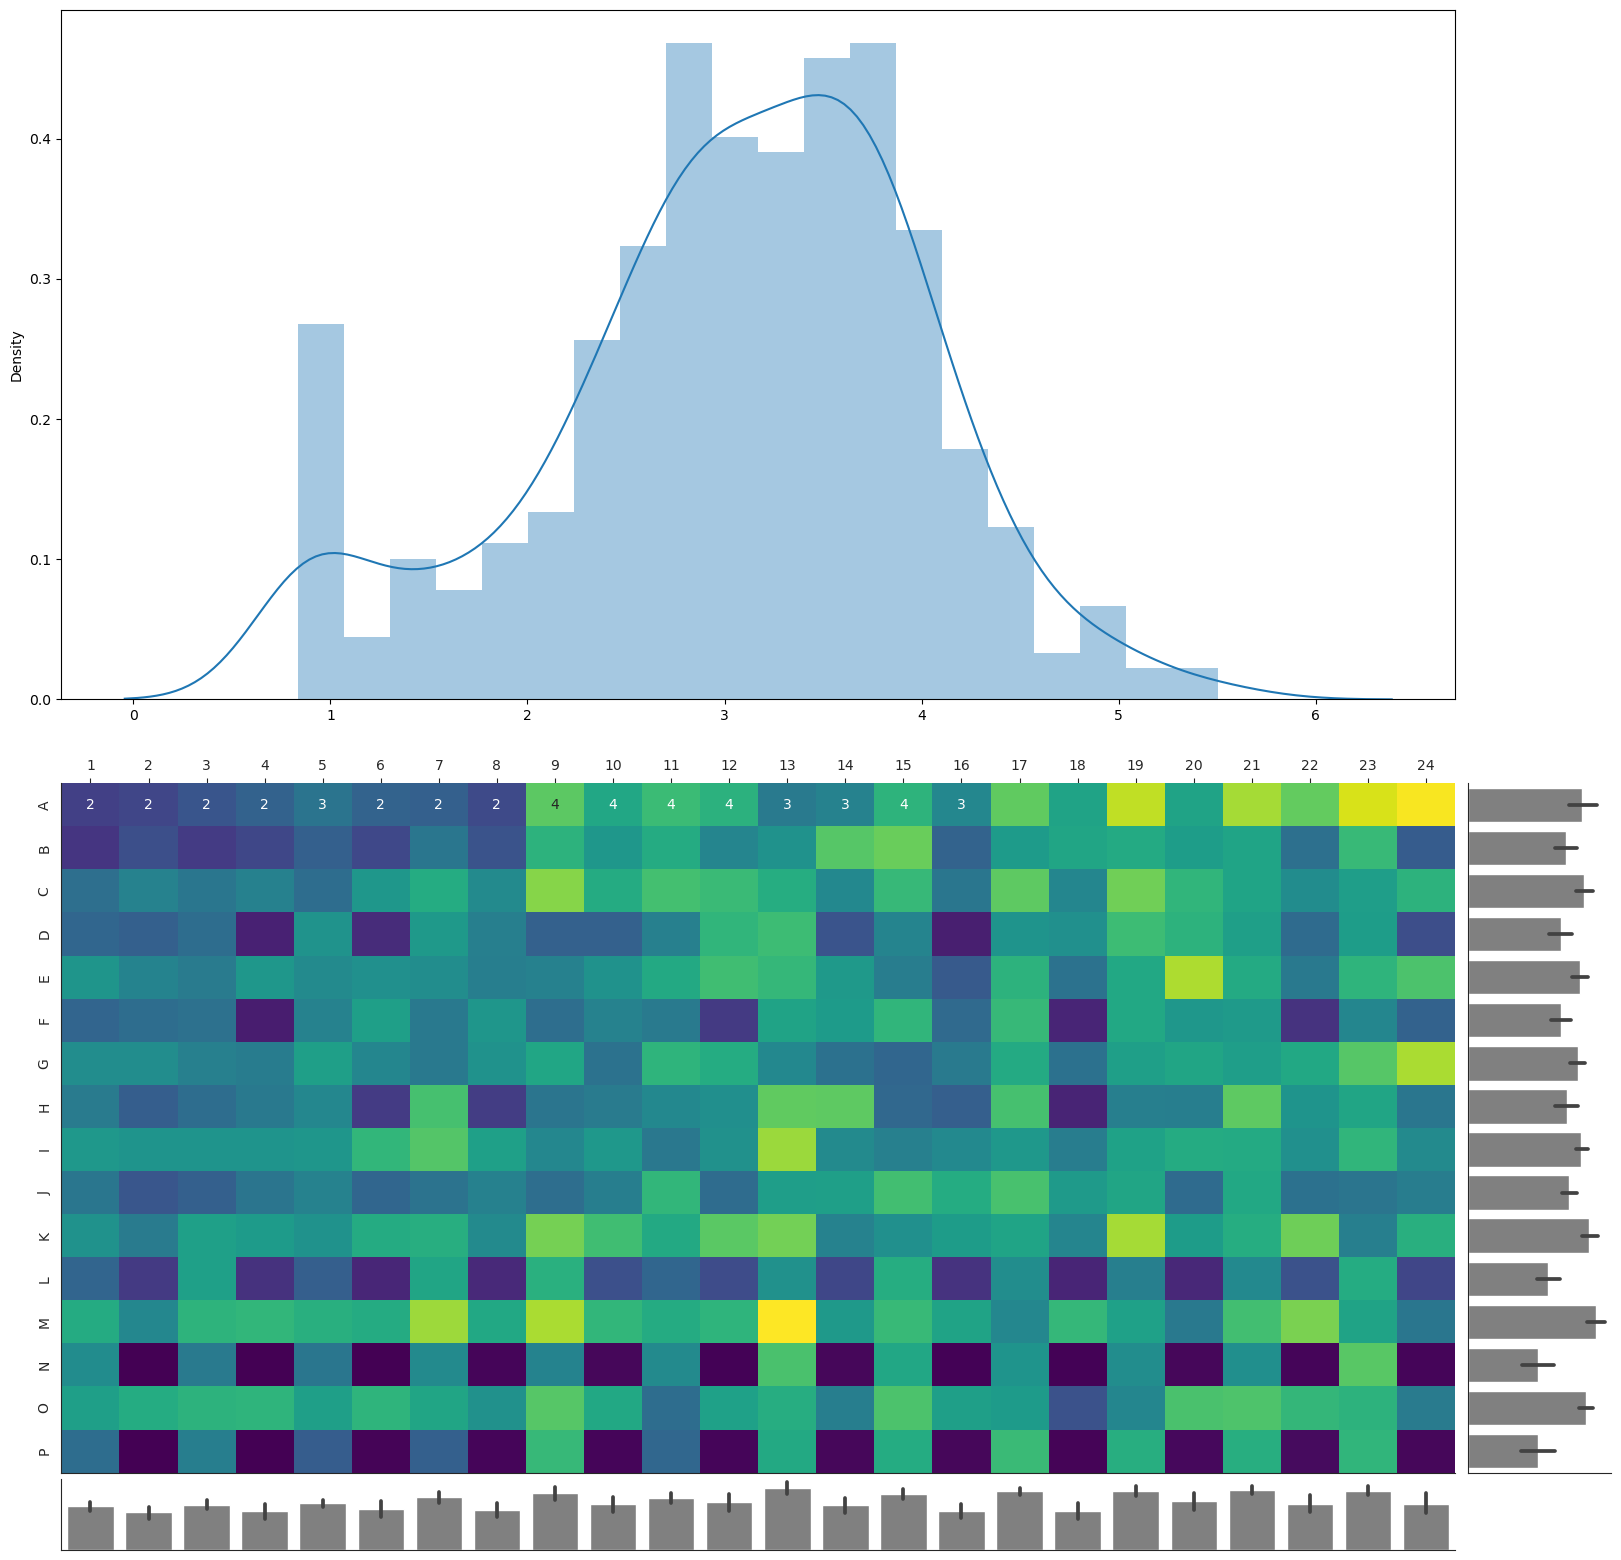

In [39]:
plot_plate_vals(concs, color_map='viridis')

### Plate maps for individual constituent plates

### Library concentration heatmap, Plate 1

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


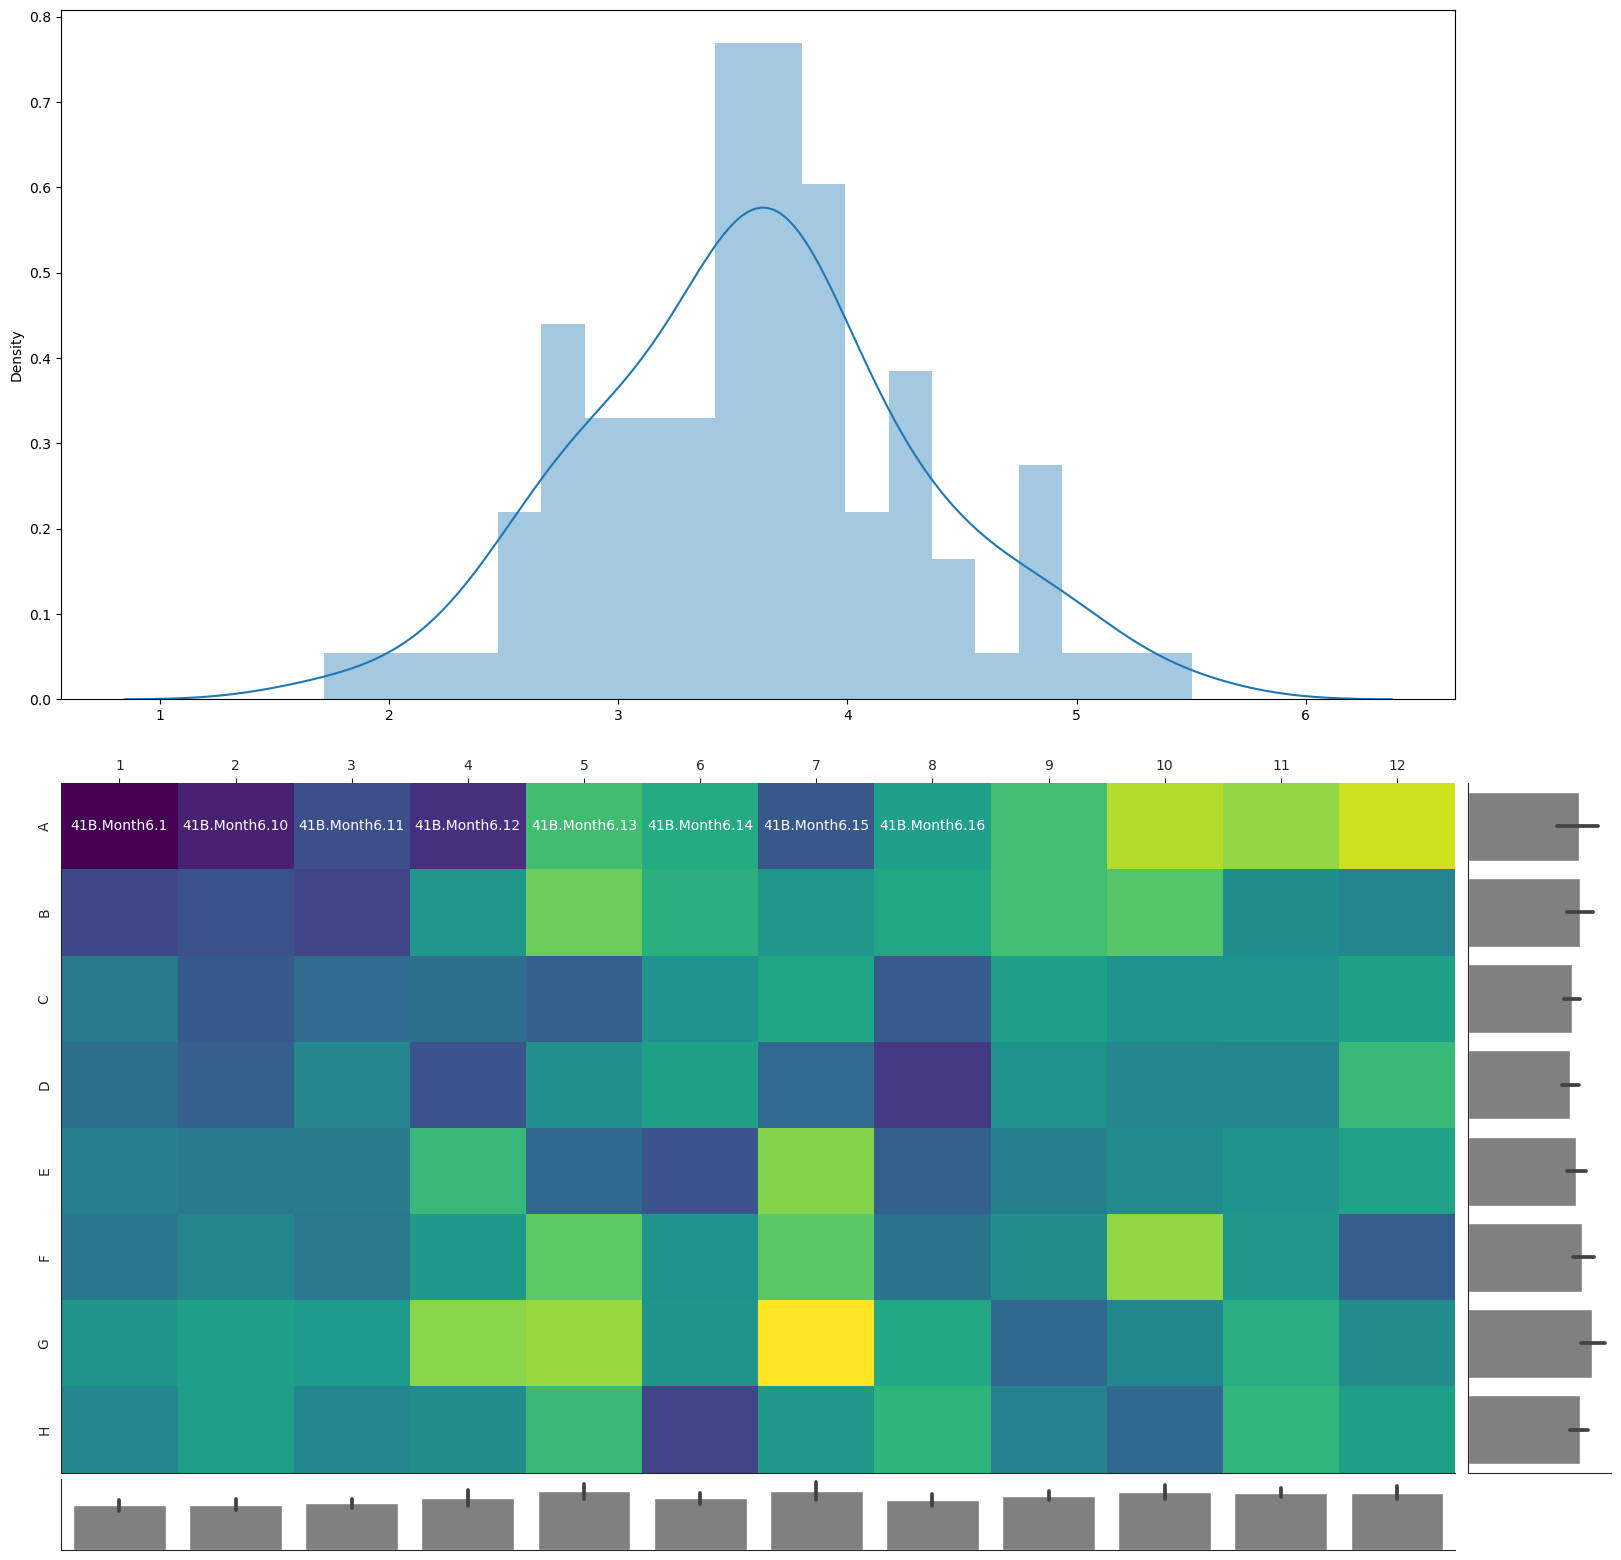

In [40]:
plot_plate_vals(concs[np.ix_(even_rows,even_cols)],
                    annot_str= names[np.ix_(even_rows,even_cols)],
                    color_map='viridis',
                    annot_fmt='')

### Library concentration heatmap, Plate 2

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


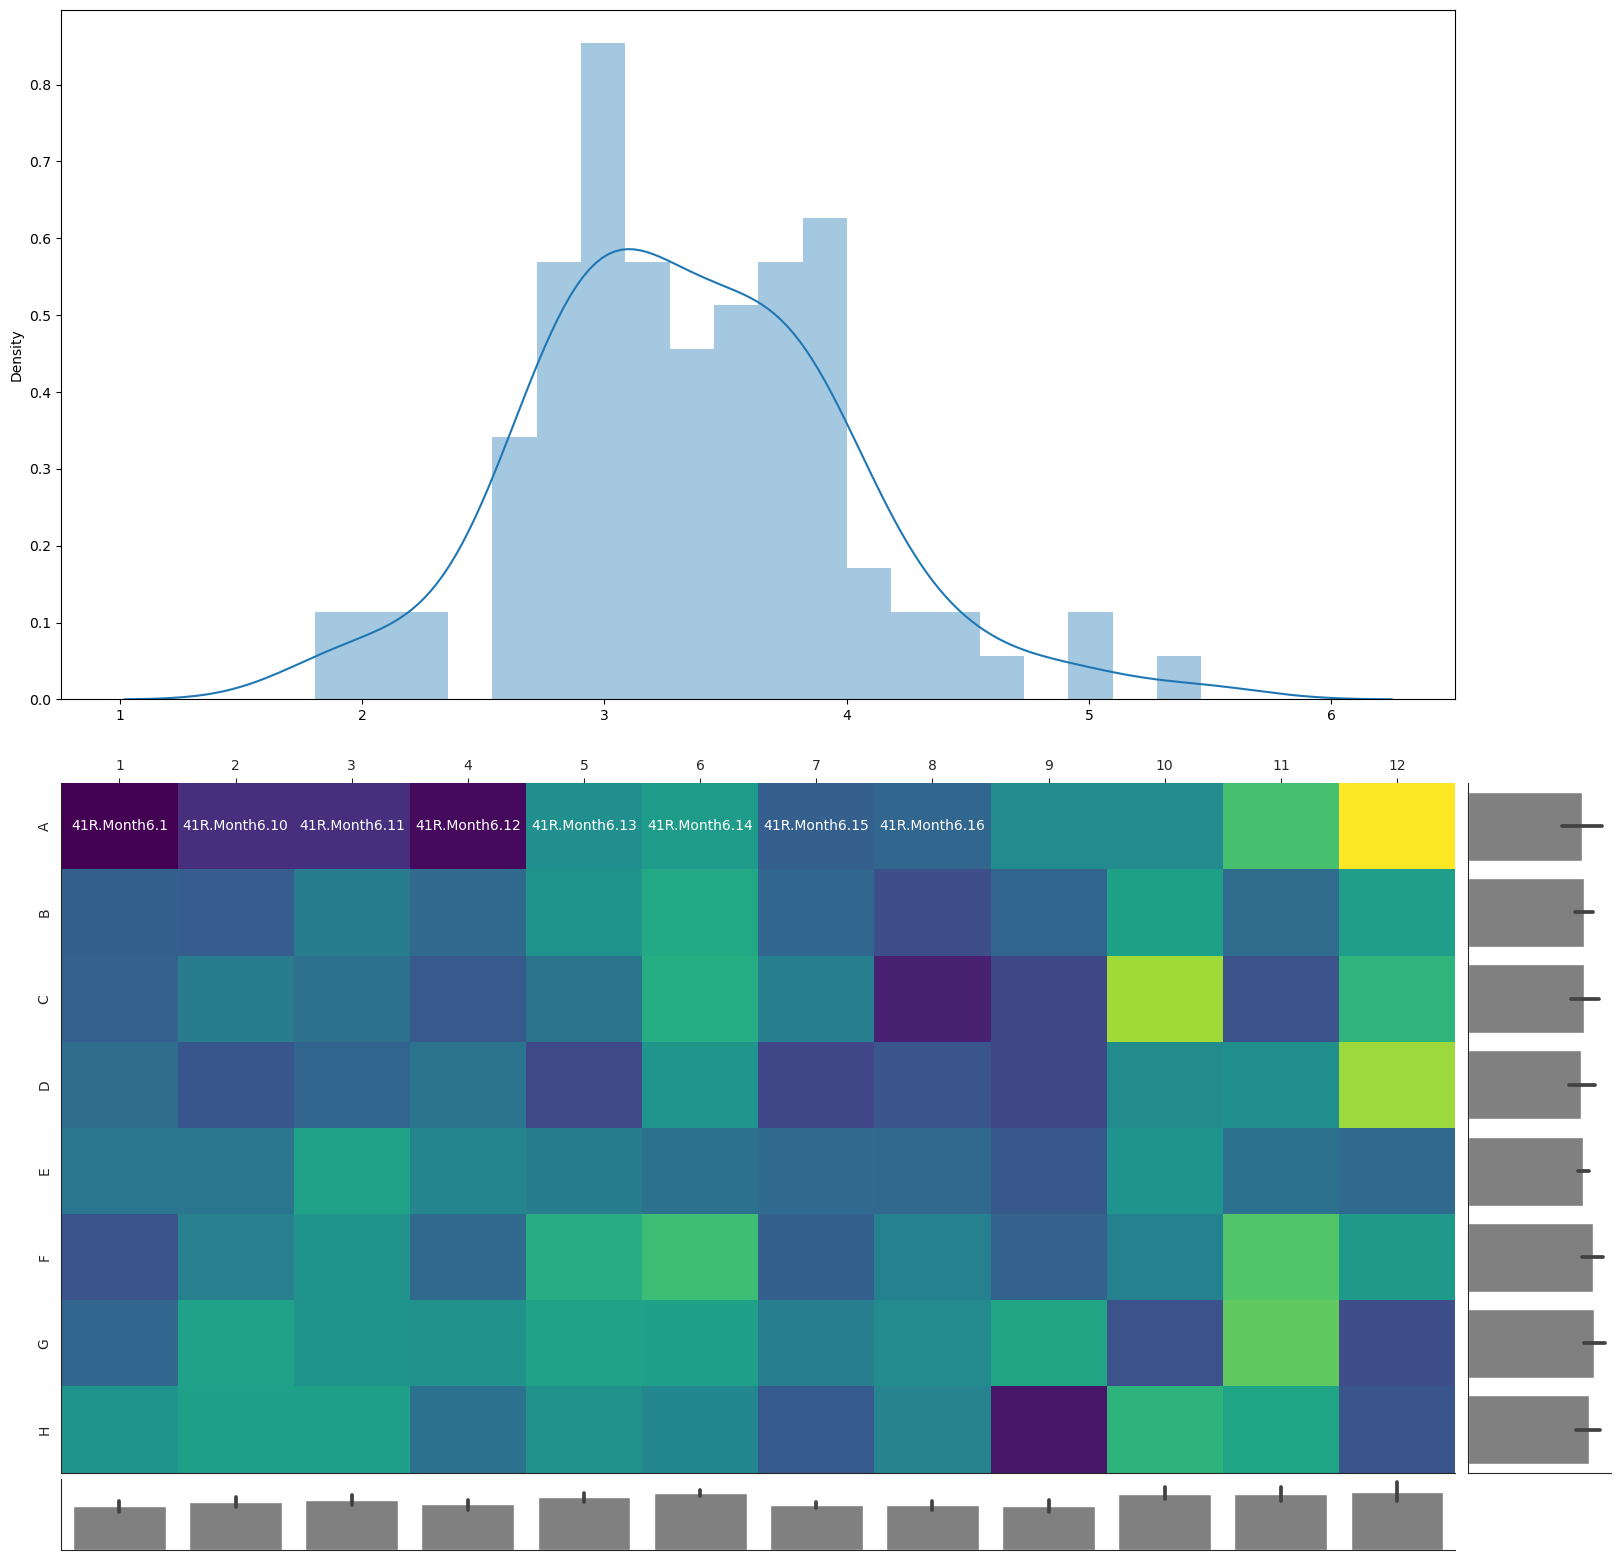

In [41]:
plot_plate_vals(concs[np.ix_(even_rows,odd_cols)],
                    annot_str= names[np.ix_(even_rows,odd_cols)],
                    color_map='viridis',
                    annot_fmt='')

### Library concentration heatmap, Plate 3

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


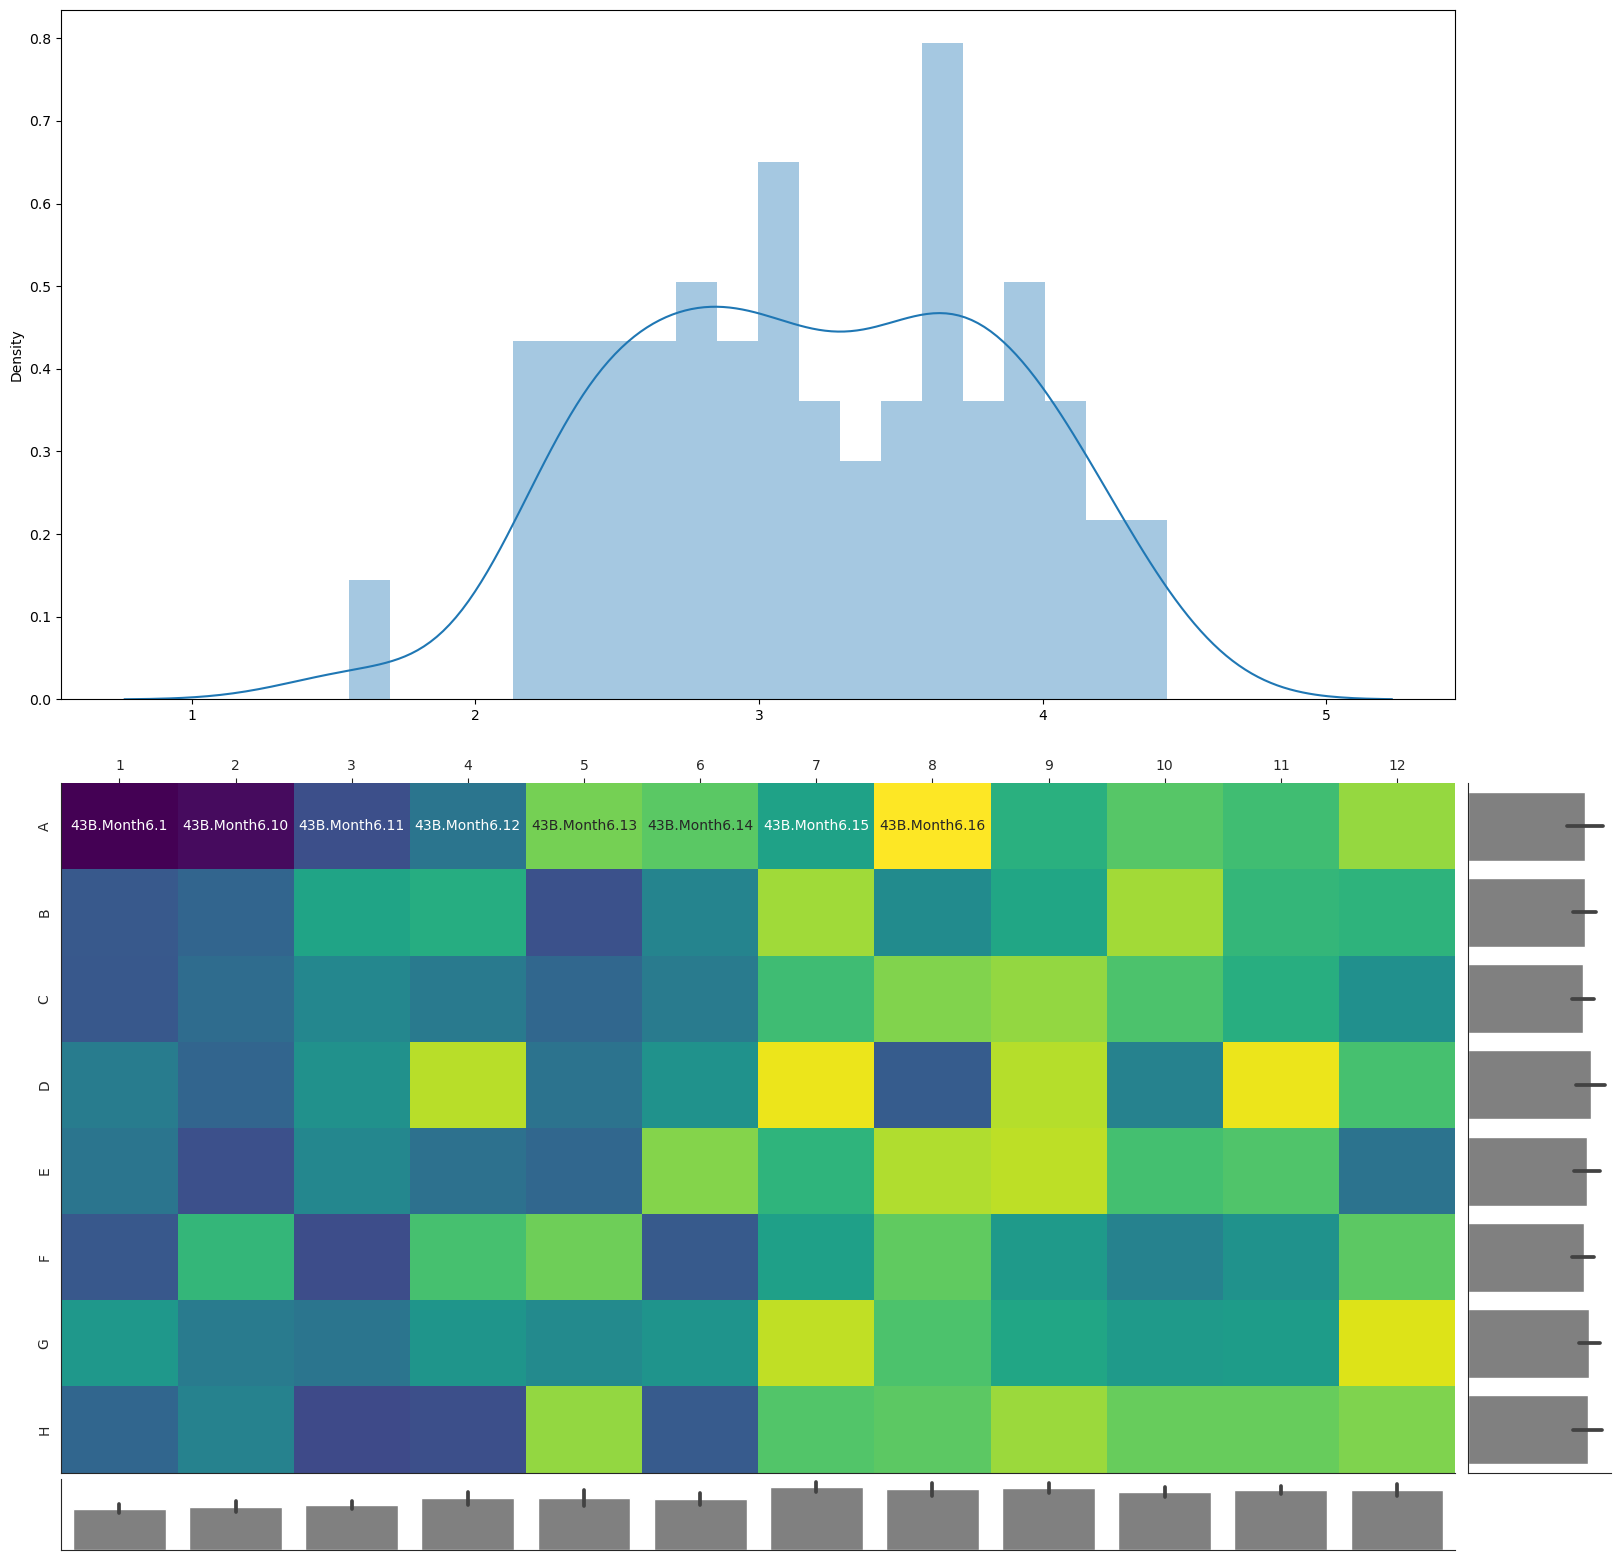

In [42]:
plot_plate_vals(concs[np.ix_(odd_rows,even_cols)],
                    annot_str= names[np.ix_(odd_rows,even_cols)],
                    color_map='viridis',
                    annot_fmt='')

### Library concentration heatmap, Plate 4

/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


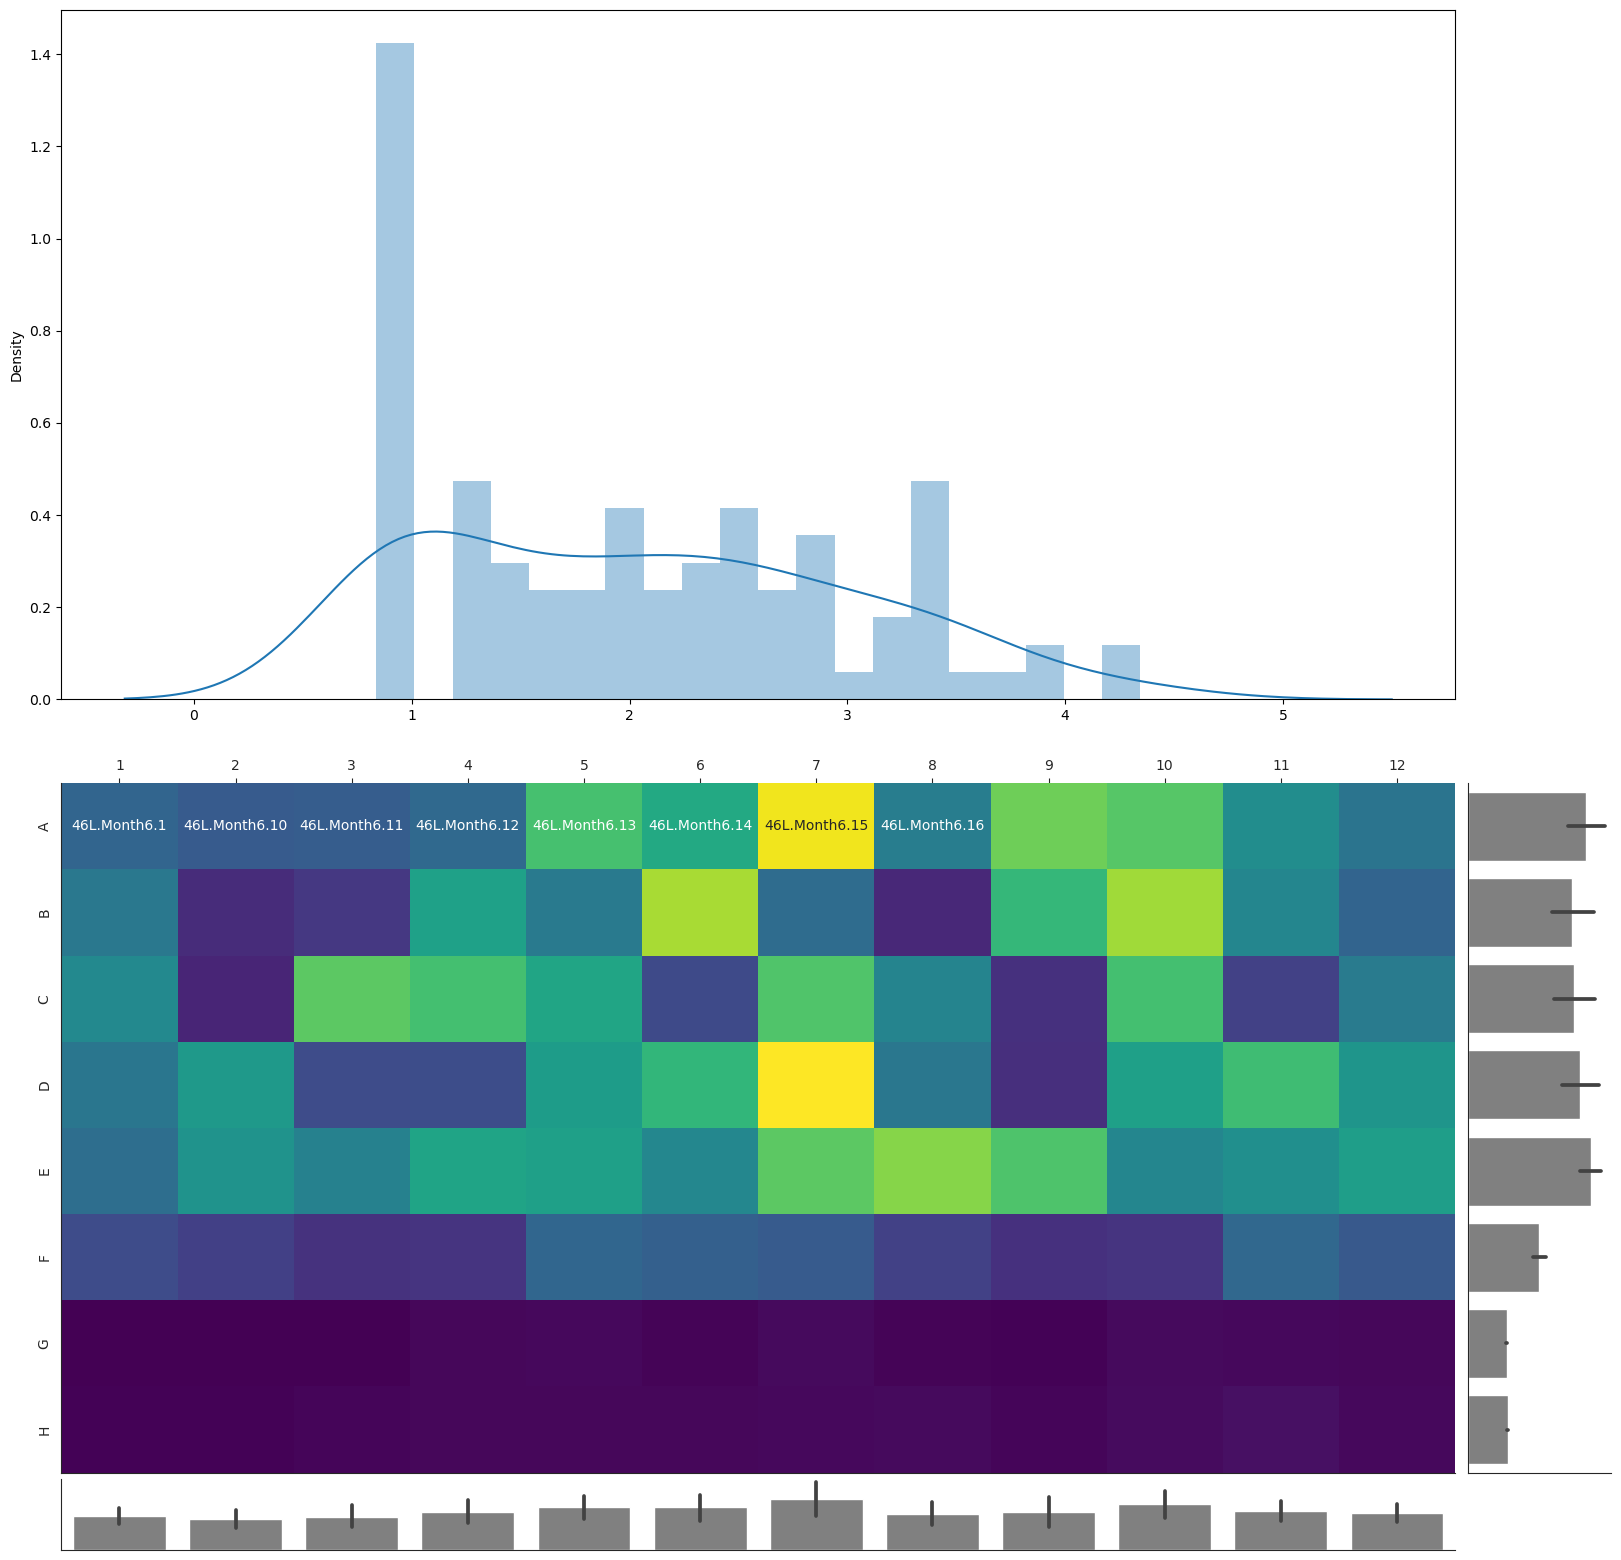

In [43]:
plot_plate_vals(concs[np.ix_(odd_rows,odd_cols)],
                    annot_str= names[np.ix_(odd_rows,odd_cols)],
                    color_map='viridis',
                    annot_fmt='')

## Step 4: calculate pooling values for MiniPico with autopool

This step will calculate the sample pooling, and update the sample data frame with the pool info.
There are two automated methods to pool:
1. **norm**: This will attempt to generate a normalized pool, automatically infering the best parameter for pooling.
    - ***pool_failures***:
        - _high_: will pool failures at the highest pooling volume from optimized pooling.
        - _low_: will pool failures at the lowest pooling volume from optimized pooling.

2. **evp**: This will pool an even volume per sample.
    - ***total_vol***: (Optional, Default: 100µL) The total volume to pool, in uL. Each sample will be pooled at 1/N of that volume.

3. **automate**: (Optional, Default = True) When False, this argument will allow one input parameters for **Legacy** arguments. 

> **Legacy**
> There are legacy parameters to control pooling behaviors when autopool automation (automate=True) returns a poor result. To use these parameters, one must pass automate=False.

>   - **min_conc**: (default: 0) This is the minimum concentration for a sample to be considered for pooling.
    Set to 0 to pool all samples, regardless of concentration. Increasing this will have the 
    effect of increasing pool concentration, at the expense of samples dropping out. 
>   - **floor_conc**: This is the lowest concentration equivalent for which a sample will be 
    accurately pooled. Samples below this concentration will be pooled to the volume that they 
    would have been if they were actually that concentration. For example, if `floor_conc=20`, 
    and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 
    10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect 
    of increasing pool concentration, but decreasing read counts for low-concentration samples. 
>   - **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing
    this will increase the overall volume of the pool.


### Calculate and plot pooling volumes

Floor concentration: 0.8424242424242425
Pool concentration: 3.04
Pool volume: 190000.00


/Users/cbrennan/Documents/GitHub/metagenomics_pooling_notebook/metapool/metapool.py:953: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,
/Users/cbrennan/miniconda3/envs/metapool_github/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


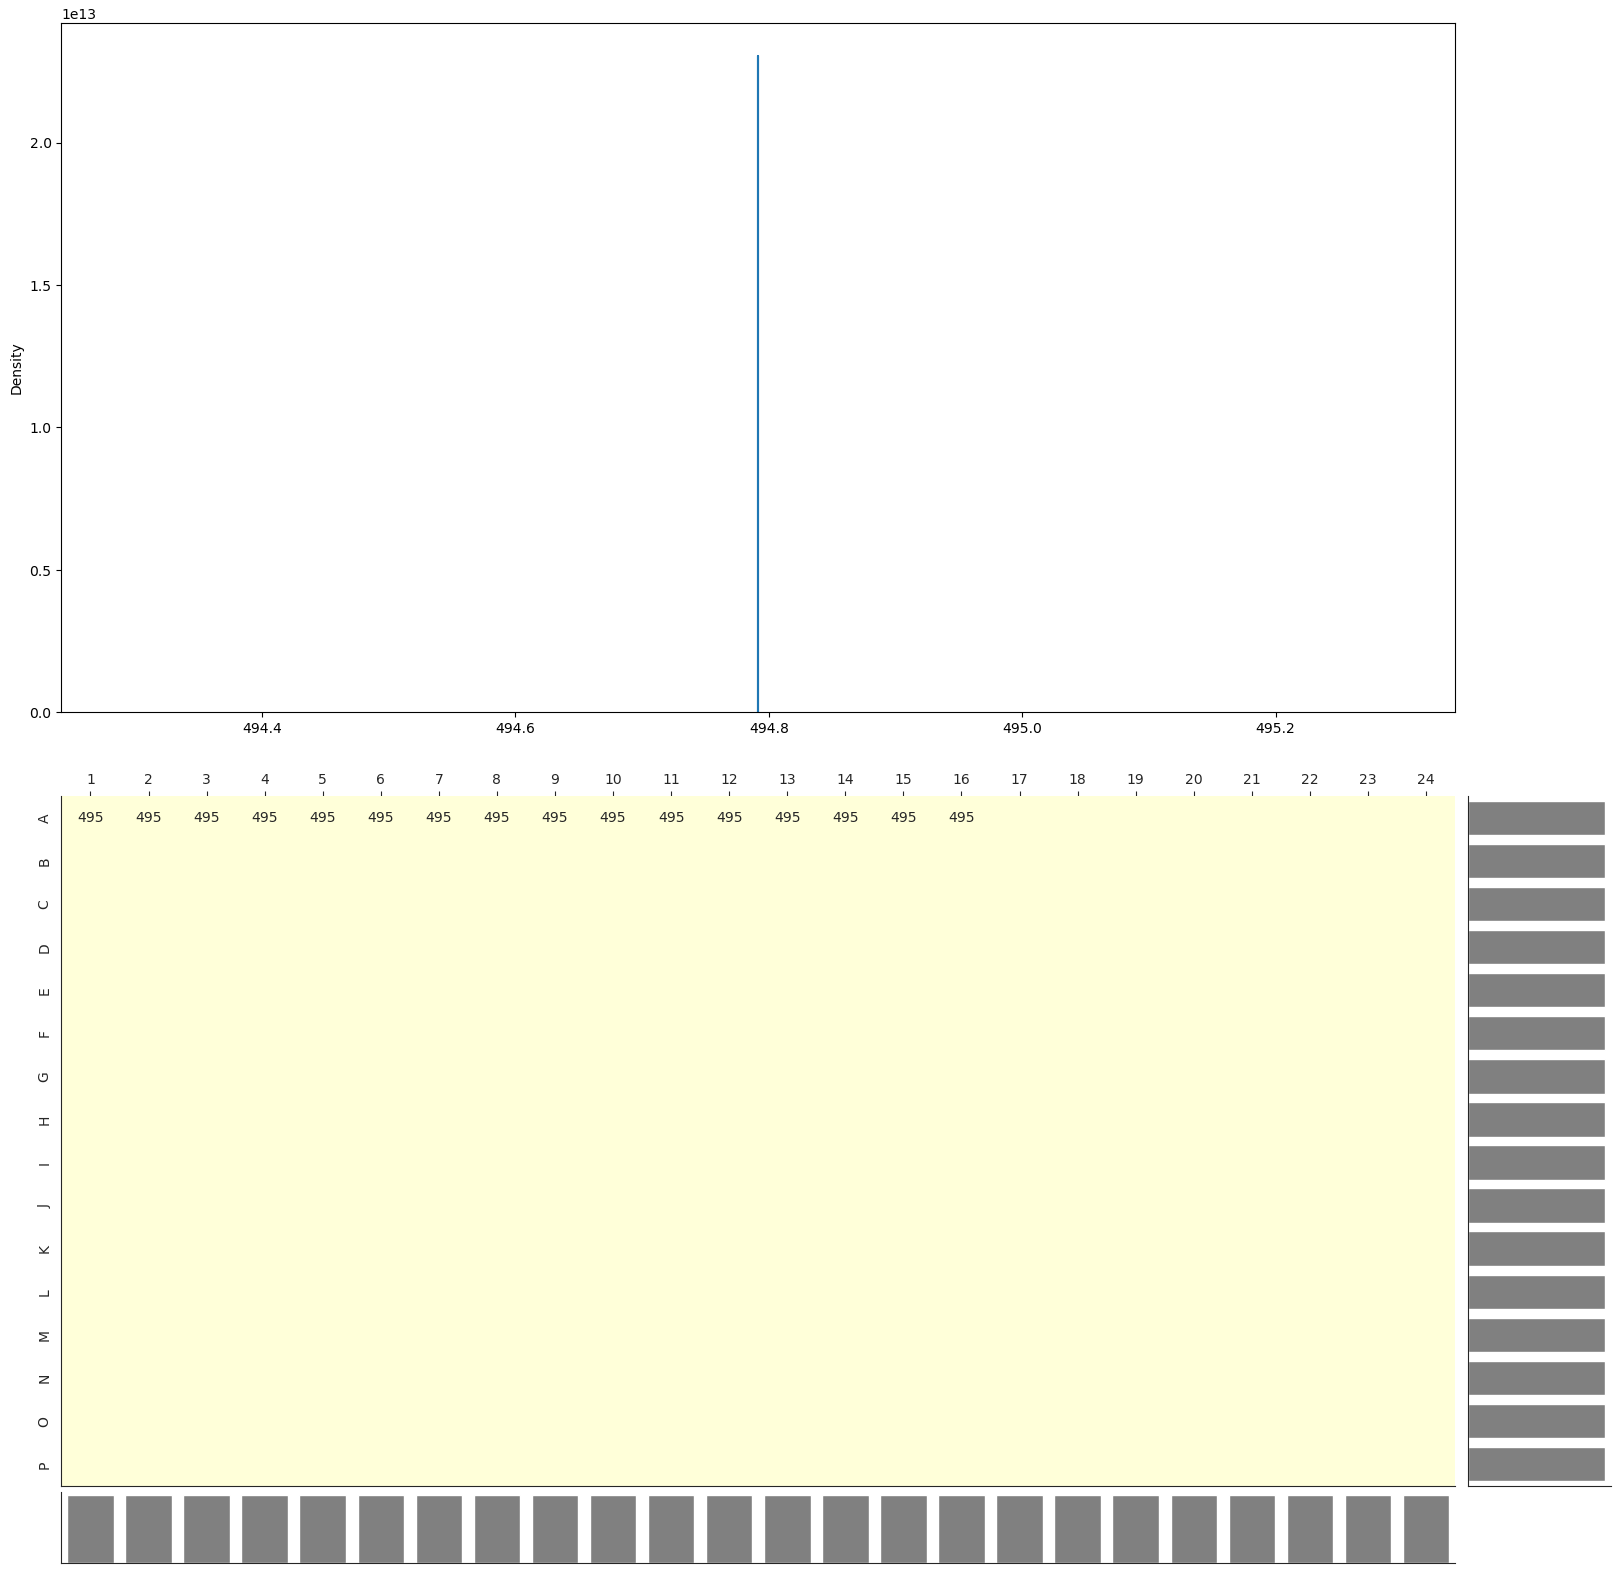

In [44]:
threshold = find_threshold(plate_df['MiniPico Library Concentration'], plate_df['Blank'])
plate_df = autopool(plate_df,method='evp',total_vol=190)

# visualize
print("Floor concentration: {}".format(threshold))
vols = make_2D_array(plate_df, data_col='MiniPico Pooled Volume', well_col=well_col).astype(float)
conc, vol = estimate_pool_conc_vol(plate_df['MiniPico Pooled Volume'], plate_df['MiniPico Library Concentration'])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

<Axes: xlabel='MiniPico Library Concentration', ylabel='MiniPico Pooled Volume'>

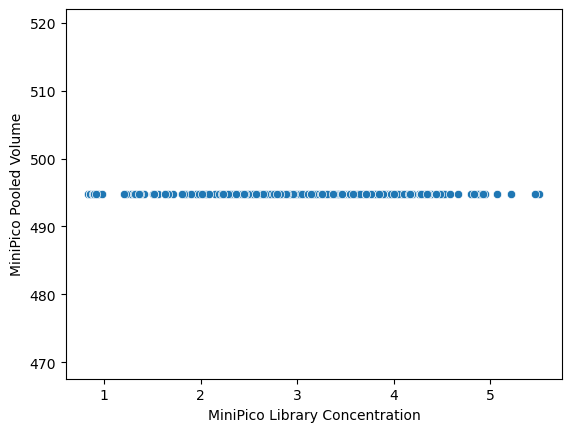

In [45]:
vols = make_2D_array(plate_df, data_col='MiniPico Pooled Volume', well_col=well_col).astype(float)
sns.scatterplot(x='MiniPico Library Concentration', y='MiniPico Pooled Volume',data=plate_df)

## Step 6: write pooling pick list

In [46]:
# Write the picklist as .csv
picklist_fp = './test_output/Pooling/YYYY_MM_DD_Celeste_Adaptation_evp.csv'

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [47]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)

!head {picklist_fp}

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2,A1,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A2,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A3,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A4,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A5,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A6,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A7,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A8,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A9,,494.79,NormalizedDNA,A1


# Write DataFrame to file

We want to keep all that useful information together in one place so it can be easily parsed later. 

In [48]:
# Write the sample info DataFrame as .txt
plate_df_fp = './test_output/QC/YYYY_MM_DD_Celeste_Adaptation_df.txt'

if os.path.isfile(plate_df_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [49]:
plate_df.to_csv(plate_df_fp, sep='\t')

# Make sample sheet

This workflow takes the pooled sample information and writes an Illumina sample sheet that can be given directly to the sequencing center. 

As inputs, this notebook requires:
1. A plate map DataFrame (from previous step)

The workflow:
1. formats sample names as bcl2fastq-compatible
2. formats sample data
3. sets values for sample sheet fields and formats sample sheet.
4. writes the sample sheet to a file

## Step 1: Format sample names to be bcl2fastq-compatible

bcl2fastq requires *only* alphanumeric, hyphens, and underscore characters. We'll replace all non-those characters
with underscores and add the bcl2fastq-compatible names to the DataFrame.

In [ ]:
plate_df['sample sheet Sample_ID'] = plate_df['Sample'].map(bcl_scrub_name)

plate_df.head()

## Step 2: format sample sheet data

This step formats the data columns appropriately for the sample sheet, using the values we've calculated previously.

The newly-created bcl2fastq-compatible names will be in the **`Sample ID`** and **`Sample Name`** columns. The
original sample names will be in the **`Description`** column.

Modify **`lanes`** to indicate which lanes this pool will be sequenced on.

**Project Name and Project Plate values will be placed in the **`Sample_Project`** and **`Sample_Name`**
columns, respectively.

**`sequencer`** is important for making sure the i5 index is in the correct orientation for demultiplexing. `NovaSeq`, `HiSeq4000`, `HiSeq3000`, `NextSeq`, `MiniSeq`, and `iSeq` all require reverse-complemented i5 index sequences. If you enter one of these exact strings in for `sequencer`, it will revcomp the i5 sequence for you.

`HiSeq2500` and `MiSeq` will not revcomp the i5 sequence. 

In [ ]:
sequencer = 'iSeq'
lanes = [1]

# Knight Lab Nextera is also valid for library_construction_protocol
metadata = {
    'Bioinformatics': [
        {
         'Sample_Project': 'Celeste_Adaptation_12986',
         'QiitaID': '12986',
         'BarcodesAreRC': 'True',
         'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
         'ReverseAdapter': 'GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT',
         'HumanFiltering': 'True',
         'library_construction_protocol': 'Knight Lab Kapa HyperPlus',
         'experiment_design_description': 'isolate sequencing',
         'contains_replicates':plate_df['contains_replicates'].all(),
        },
    ],
    'Contact': [
        {
         'Sample_Project': 'Celeste_Adaptation_12986',
         # non-admin contacts who want to know when the sequences
         # are available in Qiita
         'Email': 'rodolfo.salido@gmail.com'
        },
    ],
    'Assay': 'Metagenomic',
    'SheetType': 'standard_metag',
    'SheetVersion':'100'
}

sheet = make_sample_sheet(metadata, plate_df, sequencer, lanes)

## Step 3: Write the sample sheet to file

In [ ]:
# Write the samplesheet as .csv
sample_sheet_fp = './test_output/SampleSheets/YYYY_MM_DD_Celeste_Adaptation_12986_16_17_18_21_samplesheet.csv'

if os.path.isfile(sample_sheet_fp):
    print("Warning! This file exists already.")

In [ ]:
with open(sample_sheet_fp,'w') as f:
    sheet.write(f)
    
!head -n 30 {sample_sheet_fp}
!echo ...
!tail -n 15 {sample_sheet_fp}

# Read Distribution Summary and Pool Normalization

## Step 1: import and merge per_sample read distributions

Import a tsv file with read_counts from per_sample_fastq files and merge with growing plate_df


In [ ]:
# Import reads counts from file to dataframes

read_counts_df = pd.read_csv('./test_data/Demux/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_raw_counts.tsv',
                                 sep='\t')
raw_read_counts_df = read_counts_df.loc[~read_counts_df['Category'].str.contains('trimmed')]
filtered_read_counts_df = read_counts_df.loc[read_counts_df['Category'].str.contains('trimmed')]

##Can also import counts from Qiita per_sample_FASTQ summaries.  
# per_sample_fastq_counts_df = pd.read_csv('./test_data/Demux/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_per_sample_fastq.tsv',
#                                          sep='\t')

In [ ]:
# Merge read_counts_df with plate_df 

plate_df_w_reads = merge_read_counts(plate_df,raw_read_counts_df, reads_column_name='Raw Reads')

plate_df_w_reads = merge_read_counts(plate_df_w_reads,filtered_read_counts_df,
                                     reads_column_name='Filtered Reads')

# plate_df_w_reads = merge_read_counts(plate_df_w_reads,per_sample_fastq_counts_fp,
#                                      reads_column_name='Qiita Reads')

plate_df_w_reads.head()

In [ ]:
reads_column = 'Filtered Reads'

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# evenness plot
rmax = int(round(plate_df_w_reads[reads_column].max(),-2))
survival_df = pd.concat([read_survival(plate_df_w_reads.loc[plate_df_w_reads['Blank'] == True,
                                                            reads_column], label='Blanks',rmax=rmax),
                         read_survival(plate_df_w_reads.loc[plate_df_w_reads['Blank'] == False,
                                                            reads_column], label='Samples',rmax=rmax)])

ax3.set_xlabel(reads_column)
ax3.set_ylabel('Samples')
survival_df.plot(color = ['coral','steelblue'],ax=ax1)
ax1.set_xlabel(reads_column)
ax1.set_ylabel('Samples')

##Histogram
sns.histplot(plate_df_w_reads[reads_column],ax=ax3)

##Regressopm
sns.regplot(x="MiniPico Library DNA Concentration", y=reads_column, data=plate_df_w_reads, ax = ax2);

#Boxplot
sns.boxplot(x="Blank", y=reads_column, data=plate_df_w_reads, ax = ax4);
sns.stripplot(x="Blank", y=reads_column, data=plate_df_w_reads, ax = ax4,
              size=3,color='black',alpha=0.5)


plt.tight_layout()

## Step 2: Calculate iSeqnorm pooling volumes

In [ ]:
plate_df_normalized = calculate_iseqnorm_pooling_volumes(plate_df_w_reads,dynamic_range=5)

In [ ]:
# visualize
vols = make_2D_array(plate_df_normalized, data_col='iSeq normpool volume', well_col=well_col).astype(float)
conc, vol = estimate_pool_conc_vol(plate_df_normalized['iSeq normpool volume'], plate_df_normalized['MiniPico Library Concentration'])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

## Estimate read depth

In [ ]:
#Plots estimate of read depth proportion, and returns a df with estimates. 
plate_df_normalized_with_estimates = estimate_read_depth(plate_df_normalized)

## Step 3: write pooling picklist

In [ ]:
# Write the picklist as .csv
picklist_fp = './test_output/Pooling/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_iSeqnormpool.csv'

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

In [ ]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)

!head {picklist_fp}